# Regression models

## Imports

In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
pip install tpot

In [5]:
import tpot
from tpot.builtins import StackingEstimator

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
!pip install missingno

In [7]:
import missingno

In [8]:
!pip install shap

In [9]:
import shap

## Notes

*STEPS*

- Loading dataset
- Univariate analysis
- Multivariate analysis
- Missing values
- Preprocessing
- Modeling, evaluation
- Overfitting

NOTES

package missingno for missing value

histogramme : sn.displot()

pd.loc / pd.iloc

sklearn.input.Iterative

## 0. Data importation



The data will be downloaded via github. We need 2 files :

- data_train_insurance.csv

- data_type.csv

In [10]:
url_datatypes = "https://raw.githubusercontent.com/louis75020/ML-for-business/Regression-model/data_type.csv"
df_datatypes = pd.read_csv( url_datatypes,
                            sep = ';',
                            header = 0,
                           #encoding = "iso-8859-1" 
                           )
# check
df_datatypes.head()

VarName     Type
0                     Id   object
1  Response_Market_Index  float64
2           PROD_Formula   object
3                PER_sex   object
4  PER_Sex_Second_Driver   object

In [11]:
def get_types_dictionnary (dataframe = df_datatypes) :

  keys = dataframe['VarName']
  values = dataframe['Type']

  return dict( zip(keys, values) )

In [12]:
datatypes = get_types_dictionnary()
#datatypes

In [13]:
url_insurance_data = "https://raw.githubusercontent.com/louis75020/ML-for-business/Regression-model/data_train_insurance.csv"
df_insurance = pd.read_csv( url_insurance_data, 
                            sep = ";",
                            header = 0,
                            dtype = datatypes,
                            na_values = ['?'],
                            keep_default_na = True,
                            #encoding = "iso-8859-1" 
                           )

#check
df_insurance.head()

Id  Response_Market_Index PROD_Formula  ... VEH_Weight   GEO_Lat  GEO_Long
0  1638099                  435.0        BASIC  ...     1125.0 -1.790876 -0.431147
1  1657342                  609.0         FULL  ...     1510.0  1.675824 -4.431147
2  1657529                  609.0         FULL  ...     1510.0  1.675824 -4.431147
3  1662071                  404.0         FULL  ...     1170.0 -0.440876  1.285553
4  1662074                  404.0         FULL  ...     1170.0 -0.440876  1.285553

[5 rows x 40 columns]

In [14]:
df_insurance.dtypes

Id                                object
Response_Market_Index            float64
PROD_Formula                      object
PER_sex                           object
PER_Sex_Second_Driver             object
VEH_Actual_Value                 float64
CLA_HISTORY                      float64
CLA_HISTORY_1Y                   float64
CLA_HISTORY_3Y                   float64
CLA_BM_TPL_DECLARED              float64
BEH_Mileage                      float64
PER_KIDS_ON_BOARD_ID              object
VEH_Number_of_doors              float64
VEH_Top_Speed                    float64
BEH_Number_Year_Insured          float64
VEH_TransmissionId                object
PER_Age_Main_Driver              float64
PER_License_Age_Main_Driver      float64
PER_License_Age_Second_Driver    float64
PER_Matrimonial_Status            object
VEH_Age                          float64
VEH_Injection_Mode                object
VEH_fuel_type                     object
BEH_vehicule_usage                object
VEH_Drive_type  

## Preparation : Split qualtitative/quantitative + train/test

In [15]:
df_insurance.describe()

Response_Market_Index  VEH_Actual_Value  ...      GEO_Lat     GEO_Long
count            9983.000000      9.983000e+03  ...  9983.000000  9983.000000
mean              493.635824      2.076923e+04  ...    -0.002146    -0.007880
std               268.707675      2.473360e+04  ...     1.344643     2.032372
min               162.000000     -1.765000e+03  ...    -2.440876    -4.764447
25%               341.580000      7.803000e+03  ...    -1.274176    -1.547747
50%               407.070000      1.499800e+04  ...     0.009124     0.002253
75%               530.000000      2.688250e+04  ...     0.809124     1.702253
max              2604.930000      1.132190e+06  ...     3.055324     4.902253

[8 rows x 22 columns]

We will first split data according to their types (quantitative/ qualitative/   geographical ... ).

We will also review the data types (categorical as integers ...)

**ID** : to delete (no information to get from the id, if we need to access lines we will use the pandas auto-generated iterator).

**Response_market_index**

Quantitative variable, the one we want to explain. We will check for missing values (in order to use these ones for the test dataset).

**Product Information**

Qualitative variable. See number of modalities. To cast to integer. Eventually we'll have ton get the associated dummies.

**PER: Personnal information**

- PER_SEX, PER_SEX_SECOND_DRIVER : sexe 1/2, qualitative variable we'll need to get dummies. 
- PER_KIDS_ON_BOARD_ID : ??? maybe the number of kids of the car's owner. It maybe requires to be cast to integer, and to get dummies
- PER_AGE_MAIN_DRIVER : quantitative.
- PER_LICENCE_MAIN_DRIVER, PER_LICENCE_SECOND_DRIVER : quantitative
- PER_MATRINOMIAL_STATUS : qualitative, get_dummies, to integer
- PER_PARKING_TYPE : qualitative, get_dummies, to integer
- PER_previous_insurer 	: qualitative, get dummies
- PER_Is_second_driver 	: ??? flag 0/1
- PER_Age_oldest_child 	: quantitative
- PER_Second_Driver_Age 	: quantitative
- PER_Insured_Before : qualitative (flag)

We will have to take into account :

- CASE wo 2nd driver
- ASE wo children

**VEH : Vehicle information**

- VEH_Actual_Value : quantitative
- VEH_Number_of_doors : quantitative
- VEH_Top_Speed : quantitative
- VEH_TransmissionId : ?? qualitative, seems to be a flag
- VEH_Age : quantitative                
- VEH_Injection_Mode : ?? qualitative               
- VEH_fuel_type : qualitative             
- VEH_Drive_type : qualitative
- VEH_Body : ?? qualitative
- VEH_Segment : qualitative
- VEH_engine_HP : quantitative
- VEH_pw_proportion : quantitative
- VEH_High_Risk_Vehicle : qualitative
- VEH_Weight : quantitative

**CLA : Claims information**

Not so sure what it means. It seems to take integer values from 1 to 10. It could be treated as a qualitative or quantitative variable if we could be sure that there is some kind of distance between 11 and 1. We'll suppose it quantitative (to simplify analysis) but it's maybe a mistake.

- CLA_HISTORY : qualitative                   
- CLA_HISTORY_1Y : qualitative                     
- CLA_HISTORY_3Y : qualitative                    
- CLA_BM_TPL_DECLARED : qualitative       
- CLA_BM : quantitative  

**BEH : Behavioral information**

- BEH_Mileage : quantitative
- BEH_Number_Year_Insured : quantitative
- BEH_vehicule_usage : qualitative

**GEO : geographical data**
(GEO_LAT, GEO_LONG) : check for norm of representation

It seems that there is more qualitative variables as expected by given types. Encoding of these are bad (1/2 instead of 0/1).

In [16]:
qualitative = ["PROD_Formula",
               "PER_sex",
               "PER_Sex_Second_Driver",
               "PER_KIDS_ON_BOARD_ID",
               "VEH_TransmissionId",
               "PER_Matrimonial_Status",
               "VEH_Injection_Mode",
               "VEH_fuel_type",
               "BEH_vehicule_usage",
               "VEH_Drive_type",
               "VEH_Body",
               "VEH_Segment",
               "PER_Parking_Type",
               "VEH_High_Risk_Vehicle",
               "PER_previous_insurer",
               "PER_Is_second_driver",
               "PER_Insured_Before"]

quantitative = ["VEH_Actual_Value",
                "VEH_Top_Speed",
                "PER_Age_Main_Driver",
                "PER_License_Age_Main_Driver",
                "PER_License_Age_Second_Driver",
                "VEH_Age",
                "VEH_engine_HP",
                "VEH_pw_proportion",
                "PER_Age_oldest_child",
                "PER_Second_Driver_Age",
                "VEH_Weight"] 

as_quantitative = ["BEH_Mileage",
                   "BEH_Number_Year_Insured", 
                   "VEH_Number_of_doors", 
                   "CLA_HISTORY",
                   "CLA_HISTORY_1Y",
                   "CLA_HISTORY_3Y",
                   "CLA_BM_TPL_DECLARED", 
                   "CLA_BM"]

geographical = ["GEO_Lat", "GEO_Long"] 	 	 	 	 	 	

In [17]:
del df_insurance["Id"]

We will split now the database into train/test to avoid any bias while analyzing the data (even if it is not as conveniant...)

The final split will be about 60/ 20/ 20.

In [18]:
df_insurance['Response_Market_Index'].isnull().sum()

0

In [19]:
y = df_insurance['Response_Market_Index']
del df_insurance['Response_Market_Index'] 
#seed(2021)
X_train, X_test, y_train, y_test = train_test_split(df_insurance, y, test_size=0.20)

print ('shape X: ', X_train.shape, 'shape y: ', y_train.shape)

shape X:  (7986, 38) shape y:  (7986,)


In [20]:
del url_datatypes, url_insurance_data, df_datatypes, datatypes

## 1. Univariate analysis

We will perform the engineering for missing values later.

### Response variable

In [19]:
class Custom_univariate_statistics():

  is_categorical = False

  def quantitative_adequacy_tests(self, x):

    # initialisation
    output = dict()
    best_pvalue = 0
    best_params = {}
    best_law = 'uniform'

    to_test = ['gamma',
               'alpha',
               'beta',
               'skewnorm',
               'expon',
               'cauchy',
               'norm',
               'weibull_min',
               'uniform',
               'gumbel_r']

    for k in to_test :

      params = getattr(scipy.stats, k).fit(x)
      test = scipy.stats.kstest(x, k, args = params)
      name = k + ' ks test'
      output[ name ] = test
      if test[1] > best_pvalue :
        best_pvalue = test[1]
        if k in ['alpha',
                 'gamma',
                 'skewnorm'] : best_params = {'a': params[0],
                                              'loc': params[1],
                                              'scale':params[2]}

        elif k in ['beta'] : best_params = {'a': params[0],
                                          'b': params[1],
                                          'loc': params[2],
                                          'scale':params[3]}
        elif k in ['cauchy',
                 'expon',
                 'gumbel_r',
                 'norm',
                 'uniform'] : best_params = {'loc': params[0],
                                            'scale':params[1]}

        elif k in ['weibull_min'] : best_params = {'c':params[0],
                                                 'loc': params[1],
                                                 'scale':params[2]}
        else : print('problem')

        best_law = k

    output = pd.DataFrame(output)
    output = output.transpose()
    output.columns = ['stat value', 'p-value']

    return output, best_law, best_params


  # def qualitative_adequacy_tests(self, xx):
  #
  #   x = xx.dropna()
  #   output = dict()
  #   best_pvalue = 0
  #   best_params = {}
  #   best_law = 'randint'
  #
  #   to_test = ['binom', 'geom', 'hypergeom', 'poisson', 'randint', 'nbinom', 'nhypergeom']
  #
  #   for k in to_test :
  #
  #     params = getattr(scipy.stats, k).fit(x)
  #     test = scipy.stats.kstest(x, k, args = params)
  #     name = k + ' ks test'
  #     output[ name ] = test
  #     if test[1] > best_pvalue :
  #       best_pvalue = test[1]
  #       if k in ['binom', 'nbinom'] : best_params = {'n': params[0], 'p': params[1], 'loc': params[2]}
  #       elif k in ['geom', 'nhypergeom'] : best_params = {'p':params[0], 'loc': params[1]}
  #       elif k in ['hypergeom'] : best_params = {"M":params[0], "n":params[1], "N":params[2], "loc":params[3]}
  #       elif k in ['poisson'] : best_params = {'mu':params[0], 'loc':params[1]}
  #       elif k in ['runif'] : best_params = { "low":params[0], "high":params[1], "loc":params[2]}
  #       else : print('problem')
  #       best_law = k
  #
  #   output = pd.DataFrame(output)
  #   output = output.transpose()
  #   output.columns = ['stat value', 'p-value']
  #
  #   return output, best_law, best_params




  def get_univariate_statistics(self, x) :

    if self.is_categorical :
      self.get_qualitative_univariate_statistics(x)
    else :
      self.get_quantitative_univariate_statistics(x)


  def get_quantitative_univariate_statistics(self, xx, as_na = [-1., -1, -99., -99, 0, 0.]):

    # summary
    print('__________________Summary statistics of the response variable__________________')
    print(xx.describe())

    # preprocessing
    x = xx.dropna().values
    for na_value in as_na :
      x = x[ x != na_value ]

    # adequacy test
    print('_______________________Adequacy tests_____________________________')

    tests, best_law, best_params = self.quantitative_adequacy_tests(x)
    best_params_dict = tuple(best_params.values())
    #print(best_params_dict)
    print(tests)


    #plots
    print('_______________________Plots cdf/df_______________________')

    fig = figure()
    figsize(10,10)

    #df
    subplot(2,2,1)
    ax = sns.kdeplot(x, fill = True)
    ax.patch.set_facecolor('white')
    ax.set_xlabel('values', fontsize = 15)
    ax.set_ylabel('frequency', fontsize = 15)
    title('Kernel estimator density')
    grid(True)

    # best df
    subplot(2,2,2)
    x_vals = linspace(min(x), max(x), len(x))
    best_law_module = getattr(scipy.stats, best_law)
    y_vals = best_law_module.pdf(x_vals, **best_params)
    plot(x_vals, y_vals)
    xlabel('values')
    ylabel('frequency')
    title('Best found density :'+ best_law)
    grid(True)

    #qqplot
    ax2 = subplot(2,2,3)
    res = scipy.stats.probplot(x,
                               dist = getattr(scipy.stats, best_law),
                               sparams = best_params_dict,
                               plot = ax2)
    ax.set_title("qq_plot for best law and best params")

    #cdf
    ax3 = fig.add_subplot(2,2,4)
    ordered_x = sort(x)
    cdf_x = cumsum( 1/len(x) * ones((len(x),)) )
    ax3 = plot(ordered_x, cdf_x)
    title('CDF')
    grid(True)
    xlabel('x values')
    ylabel('P(x<=t)')

    show(fig)

  def get_qualitative_univariate_statistics(self, xx, as_na = []):


    # summary
    print('__________________Summary statistics of the response variable__________________')
    print(xx.describe())

    # adequacy test
    # print('_______________________Adequacy tests_____________________________')
    #
    # tests, best_law, best_params = self.qualitative_adequacy_tests(x)
    # best_params_dict = tuple(best_params.values())
    # #print(best_params_dict)
    # print(tests)

    # preprocessing
    x = xx.dropna().values
    for na_value in as_na :
      x = x[ x!= na_value]

    print('_________________plots________________')
    figsize(10,10)
    sns.displot(x)
    grid(True)
    title('Histogram for '+element)
    show()

    #cdf
    ordered_x = sort(x)
    cdf_x = cumsum( 1/len(ordered_x) * ones(ordered_x.shape) )
    subplot(2, 2 ,2)
    plot(ordered_x, cdf_x)
    xlabel('x values')
    ylabel('P(x<=t)')
    grid(True)
    title('CDF of the vraiable ' + element)
    show()

__________________Summary statistics of the response variable__________________
count    7986.000000
mean      494.103705
std       267.223990
min       162.000000
25%       342.017500
50%       408.250000
75%       531.660000
max      2604.930000
Name: Response_Market_Index, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value        p-value
gamma ks test          0.997413   0.000000e+00
alpha ks test          0.026989   1.771222e-05
beta ks test           0.127556  2.748366e-113
skewnorm ks test       0.206718  7.696449e-297
expon ks test          0.251852   0.000000e+00
cauchy ks test         0.142126  1.528182e-140
norm ks test           0.200977  1.319985e-280
weibull_min ks test    0.814228   0.000000e+00
uniform ks test        0.646453   0.000000e+00
gumbel_r ks test       0.116673   7.516033e-95
_______________________Plots cdf/df_______________________


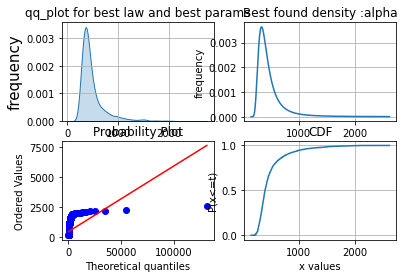

In [20]:


analyzer = Custom_univariate_statistics()

analyzer.is_categorical = False

analyzer.get_univariate_statistics(y_train)


**About the law** alpha, even if the kolmogorov-smirnov test and the qq-plot are bad. Let's note that the KS test behaves badly with large data (size > 100). To find the most likely density function, we performed ks-tests on data against laws from a defined family and with the MLE parameters. 

**About descriptive statistics** The max seems out of the natural confidence interval of the gaussian law. We won't perform any feature engineering at this point (because we are not studying Y but $E[Y|X]$...

### Quantitative variables

In [21]:
X_train[quantitative].describe()

VEH_Actual_Value  VEH_Top_Speed  ...  PER_Second_Driver_Age   VEH_Weight
count      7.986000e+03    7949.000000  ...            7949.000000  7949.000000
mean       2.080228e+04     187.517172  ...               4.361303  1312.894201
std        2.569562e+04      24.649171  ...              13.025933   249.432759
min       -1.765000e+03       0.000000  ...              -1.000000   600.000000
25%        7.787000e+03     175.000000  ...              -1.000000  1154.000000
50%        1.494800e+04     187.000000  ...              -1.000000  1318.000000
75%        2.695200e+04     201.000000  ...              -1.000000  1470.000000
max        1.132190e+06     325.000000  ...              69.000000  2475.000000

[8 rows x 11 columns]

**VEH_Actual_Value** min value is negative?? Does it have a sense?? Maybe we shoul apply there the positive part function.

**7945/7986** Once again BEH_Mileage, VEH_Top_Speed, CLA_History_1Y, CLA_History_3Y, CLA_BM_TPL_DECLARED 	BEH_Number_Year_Insured 	PER_Age_Main_Driver 	PER_License_Age_Main_Driver, VEH_Age 	CLA_BM 	VEH_engine_HP 	VEH_pw_proportion 	PER_Age_oldest_child 	PER_Second_Driver_Age 	VEH_Weight have 7945/7986. We will check later if these missing values are really the same. If this is the case; we'll have to find a solution (which is not inputation) to deal with.

**VEH_TOP_SPEED** min at 0?? Broken vehicle?

**CLA** The means are not the same, but we will check for linear independance anyway.

**CLA_BM_TPL_DECLARED, 	BEH_Number_Year_Insured** min at -1 : additionnal missing values ?

**PER_License_Age_Main_Driver** min at 0 : licence-free driver?

**PER_License_Age_Second_Driver, PER_Second_Driver_Age** min at -1 : it is maybe the vehicle with only 1 driver. We should cast to 0/1 flag and second_driver (if not 0-value).

**PER_Age_oldest_child** min at -99 -> should be casted to 0.



################################################
________________VEH_Actual_Value__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7.986000e+03
mean     2.080228e+04
std      2.569562e+04
min     -1.765000e+03
25%      7.787000e+03
50%      1.494800e+04
75%      2.695200e+04
max      1.132190e+06
Name: VEH_Actual_Value, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


                     stat value        p-value
gamma ks test          0.377788   0.000000e+00
alpha ks test          0.998459   0.000000e+00
beta ks test           0.095576   3.876502e-63
skewnorm ks test       0.180620  2.138804e-224
expon ks test          0.134941  1.949598e-125
cauchy ks test         0.169842  1.822867e-198
norm ks test           0.213682  6.783847e-314
weibull_min ks test    0.069020   3.951138e-33
uniform ks test        0.912307   0.000000e+00
gumbel_r ks test       0.078456   1.104371e-42
_______________________Plots cdf/df_______________________


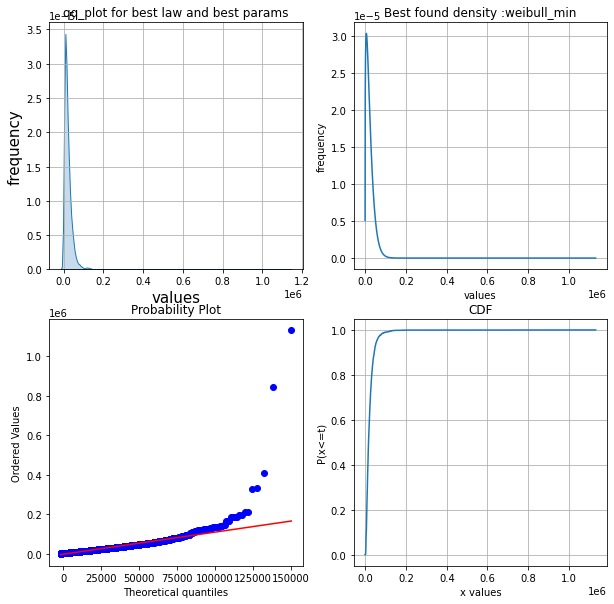

################################################
________________VEH_Top_Speed__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean      187.517172
std        24.649171
min         0.000000
25%       175.000000
50%       187.000000
75%       201.000000
max       325.000000
Name: VEH_Top_Speed, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.034783  9.598852e-09
alpha ks test          0.036224  1.901320e-09
beta ks test           0.033867  2.598805e-08
skewnorm ks test       0.034814  9.281995e-09
expon ks test          0.407995  0.000000e+00
cauchy ks test         0.086590  5.597497e-52
norm ks test           0.046432  3.003979e-15
weibull_min ks test    0.845920  0.000000e+00
uniform ks test        0.410951  0.000000e+00
gumbel_r ks test       0.074520  1.314041e-38
_______________________Plots cdf/df_______________________


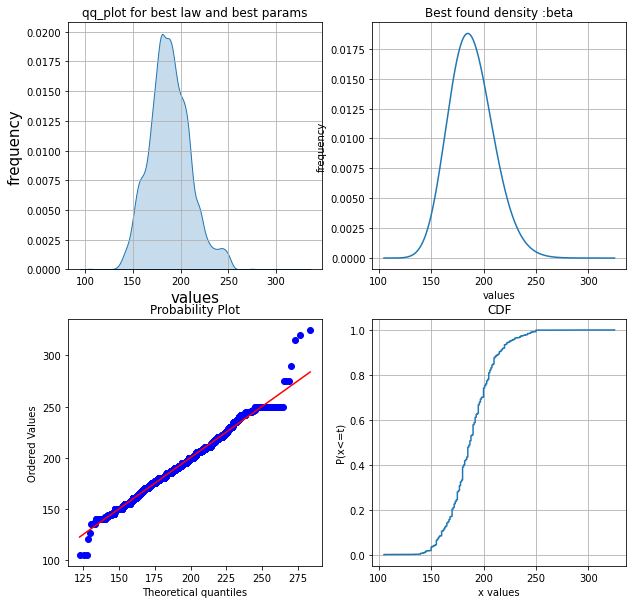

################################################
________________PER_Age_Main_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean       38.291735
std        12.213287
min        18.000000
25%        29.000000
50%        35.000000
75%        45.000000
max        85.000000
Name: PER_Age_Main_Driver, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


                     stat value        p-value
gamma ks test          0.046053   4.545538e-15
alpha ks test          0.054058   1.332945e-20
beta ks test           0.052522   1.797150e-19
skewnorm ks test       0.047505   5.240626e-16
expon ks test          0.215234  2.814198e-320
cauchy ks test         0.127682  5.504422e-113
norm ks test           0.112972   1.518946e-88
weibull_min ks test    0.741030   0.000000e+00
uniform ks test        0.350066   0.000000e+00
gumbel_r ks test       0.058693   3.281516e-24
_______________________Plots cdf/df_______________________


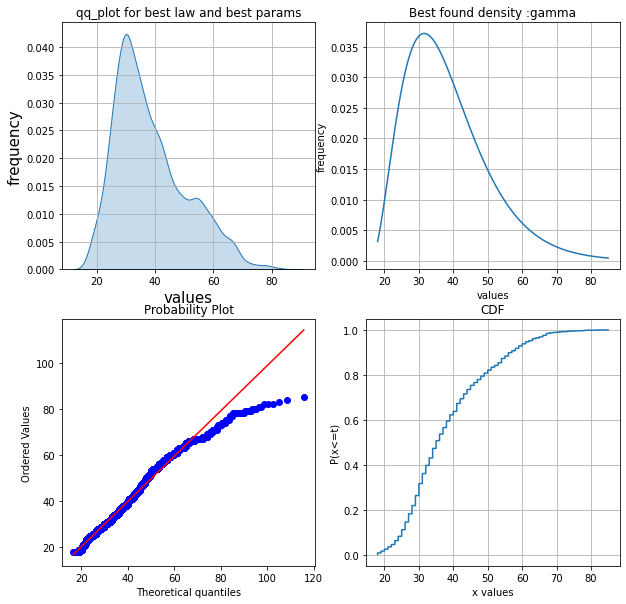

################################################
________________PER_License_Age_Main_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean       16.935589
std        11.583198
min         0.000000
25%         8.000000
50%        15.000000
75%        24.000000
max        59.000000
Name: PER_License_Age_Main_Driver, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


                     stat value        p-value
gamma ks test          0.049422   9.882482e-17
alpha ks test          0.060036   1.730958e-24
beta ks test           0.038293   3.247845e-10
skewnorm ks test       0.036711   2.013238e-09
expon ks test          0.135926  9.048221e-124
cauchy ks test         0.149559  9.405273e-150
norm ks test           0.103725   2.984948e-72
weibull_min ks test    0.555788   0.000000e+00
uniform ks test        0.360467   0.000000e+00
gumbel_r ks test       0.059292   6.784438e-24
_______________________Plots cdf/df_______________________


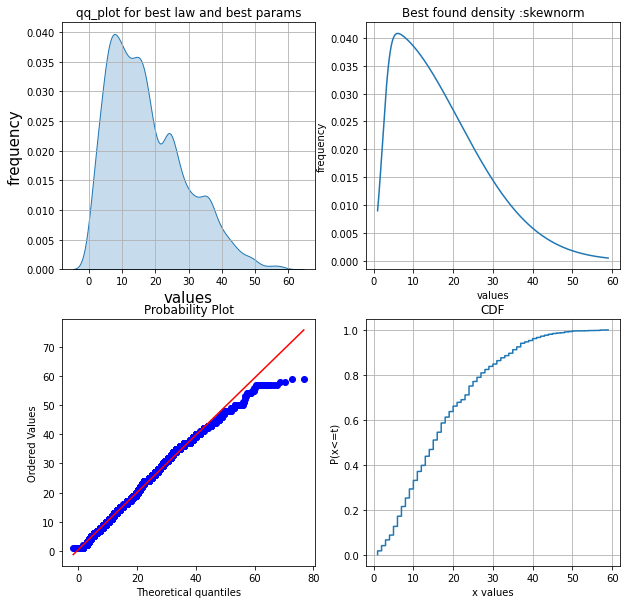

################################################
________________PER_License_Age_Second_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7151.000000
mean        0.821004
std         5.429097
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        43.000000
Name: PER_License_Age_Second_Driver, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


                     stat value        p-value
gamma ks test          0.065445   2.421529e-04
alpha ks test          0.264466   4.011211e-65
beta ks test           0.060757   8.400948e-04
skewnorm ks test       0.058065   1.646092e-03
expon ks test          0.105773   1.182079e-10
cauchy ks test         0.166734   6.567356e-26
norm ks test           0.114384   2.172411e-12
weibull_min ks test    0.365487  7.056042e-126
uniform ks test        0.446173  1.477710e-190
gumbel_r ks test       0.078673   4.394252e-06
_______________________Plots cdf/df_______________________


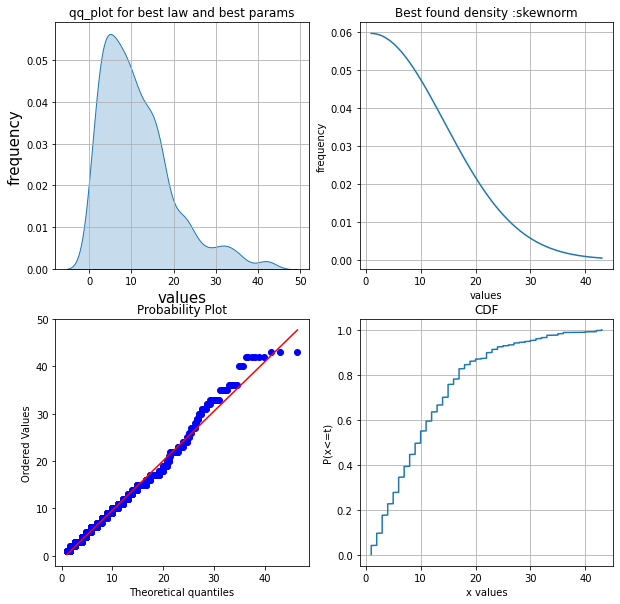

################################################
________________VEH_Age__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        8.789911
std         5.001122
min         0.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        29.000000
Name: VEH_Age, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


                     stat value        p-value
gamma ks test          0.065437   3.906342e-29
alpha ks test          0.206971  1.243237e-287
beta ks test           0.058653   1.721940e-23
skewnorm ks test       0.059158   6.874593e-24
expon ks test          0.208589  3.854171e-292
cauchy ks test         0.131008  1.694325e-115
norm ks test           0.104202   3.172138e-73
weibull_min ks test    0.517374   0.000000e+00
uniform ks test        0.394028   0.000000e+00
gumbel_r ks test       0.072523   1.089486e-35
_______________________Plots cdf/df_______________________


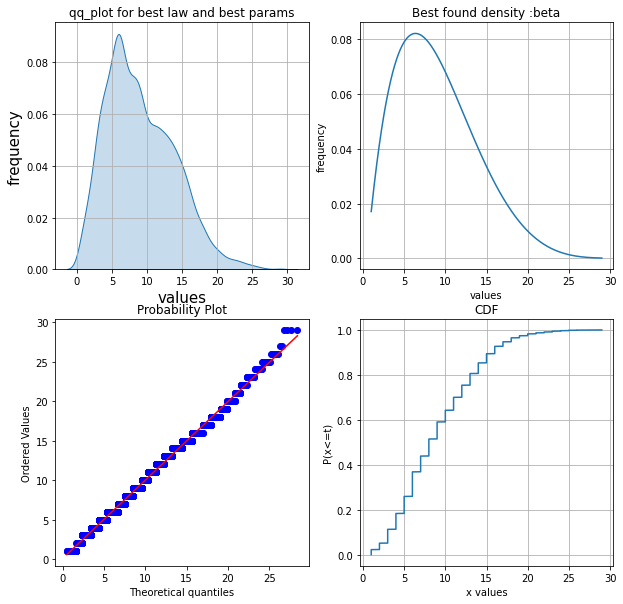

################################################
________________VEH_engine_HP__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean      116.364197
std        42.480575
min        24.000000
25%        90.000000
50%       110.000000
75%       140.000000
max       625.000000
Name: VEH_engine_HP, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.061137  3.117978e-26
alpha ks test          0.060962  4.378384e-26
beta ks test           0.063451  3.186100e-28
skewnorm ks test       0.075905  3.319907e-40
expon ks test          0.304659  0.000000e+00
cauchy ks test         0.101821  5.238882e-72
norm ks test           0.088683  9.998099e-55
weibull_min ks test    0.799913  0.000000e+00
uniform ks test        0.681087  0.000000e+00
gumbel_r ks test       0.065112  1.070616e-29
_______________________Plots cdf/df_______________________


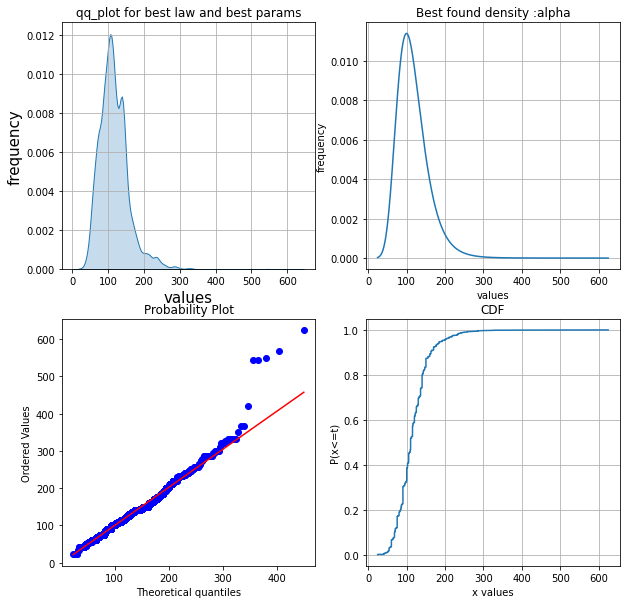

################################################
________________VEH_pw_proportion__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean       64.571267
std        15.043189
min        30.000000
25%        55.000000
50%        63.000000
75%        71.000000
max       304.000000
Name: VEH_pw_proportion, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.043954  9.161782e-14
alpha ks test          0.033152  5.159469e-08
beta ks test           0.043998  8.611721e-14
skewnorm ks test       0.054353  8.006255e-21
expon ks test          0.324103  0.000000e+00
cauchy ks test         0.102305  1.088216e-72
norm ks test           0.092261  3.384737e-59
weibull_min ks test    0.077348  9.861284e-42
uniform ks test        0.733597  0.000000e+00
gumbel_r ks test       0.036135  1.930546e-09
_______________________Plots cdf/df_______________________


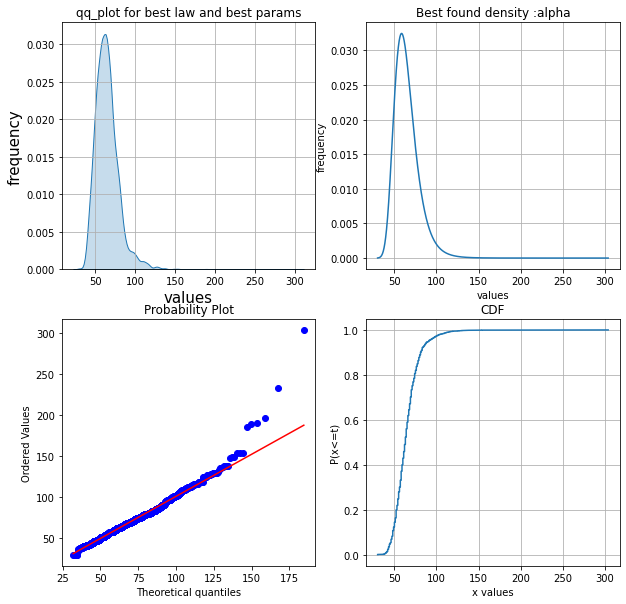

################################################
________________PER_Age_oldest_child__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean      -44.823877
std        55.381544
min       -99.000000
25%       -99.000000
50%       -99.000000
75%        10.000000
max        26.000000
Name: PER_Age_oldest_child, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


                     stat value        p-value
gamma ks test          0.219424  8.958057e-164
alpha ks test          0.095084   4.244022e-31
beta ks test           0.087046   3.932878e-26
skewnorm ks test       0.088221   7.861661e-27
expon ks test          0.122916   1.103544e-51
cauchy ks test         0.183329  1.877702e-114
norm ks test           0.113500   3.935328e-44
weibull_min ks test    0.332339   0.000000e+00
uniform ks test        0.168797   4.313676e-97
gumbel_r ks test       0.091719   5.759455e-29
_______________________Plots cdf/df_______________________


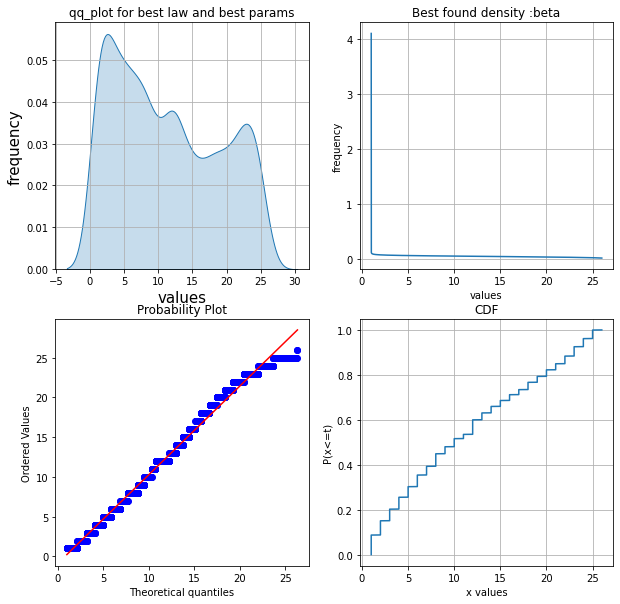

################################################
________________PER_Second_Driver_Age__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        4.361303
std        13.025933
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        69.000000
Name: PER_Second_Driver_Age, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


                     stat value        p-value
gamma ks test          0.049530   4.189233e-03
alpha ks test          0.042012   2.355562e-02
beta ks test           0.061262   1.606336e-04
skewnorm ks test       0.060100   2.288190e-04
expon ks test          0.191894   8.672426e-41
cauchy ks test         0.122559   8.032755e-17
norm ks test           0.112931   2.422716e-14
weibull_min ks test    0.679604   0.000000e+00
uniform ks test        0.385020  3.127658e-167
gumbel_r ks test       0.042836   1.976668e-02
_______________________Plots cdf/df_______________________


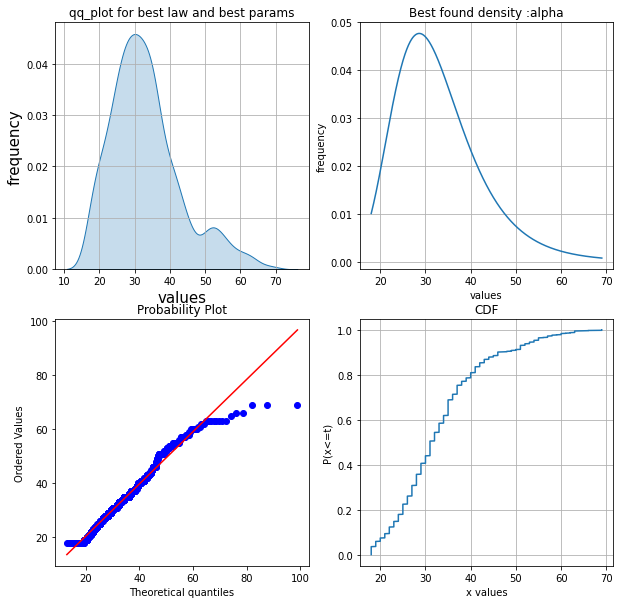

################################################
________________VEH_Weight__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean     1312.894201
std       249.432759
min       600.000000
25%      1154.000000
50%      1318.000000
75%      1470.000000
max      2475.000000
Name: VEH_Weight, dtype: float64
_______________________Adequacy tests_____________________________


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                     stat value       p-value
gamma ks test          0.029675  1.663433e-06
alpha ks test          0.043733  1.246538e-13
beta ks test           0.030031  1.185861e-06
skewnorm ks test       0.029161  2.690702e-06
expon ks test          0.334849  0.000000e+00
cauchy ks test         0.073975  3.298304e-38
norm ks test           0.031437  3.002450e-07
weibull_min ks test    0.826862  0.000000e+00
uniform ks test        0.370605  0.000000e+00
gumbel_r ks test       0.072615  7.845593e-37
_______________________Plots cdf/df_______________________


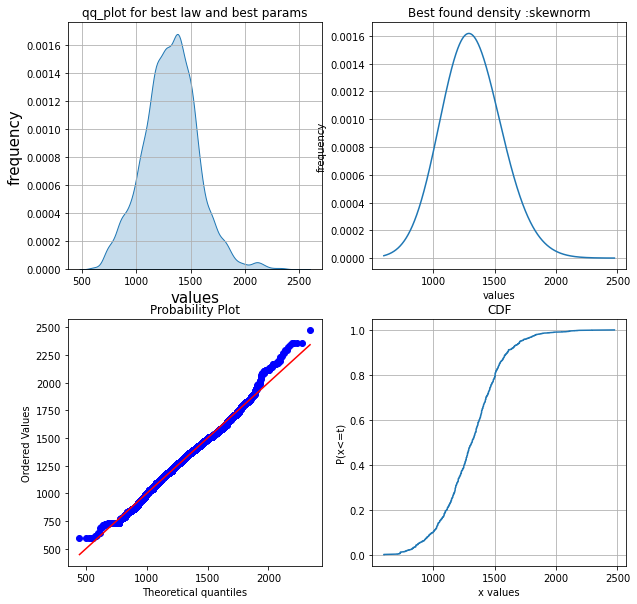

In [22]:
analyzer.is_categorical = False

for element in quantitative :

  print('################################################')
  print("________________" + element + "__________________")
  print("#################################################")

  analyzer.get_univariate_statistics(X_train[element])
  

Let's note that some of the previous plots are irrelevent (the kde windows are not adjusted, and the cdf are strongly dependant of the missing values - not NA). Moreover, some of variables are treated as continuous, while they take integer values...

################################################
________________BEH_Mileage__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean       13.310354
std         1.019893
min        12.000000
25%        13.000000
50%        13.000000
75%        14.000000
max        18.000000
Name: BEH_Mileage, dtype: float64
_________________plots________________


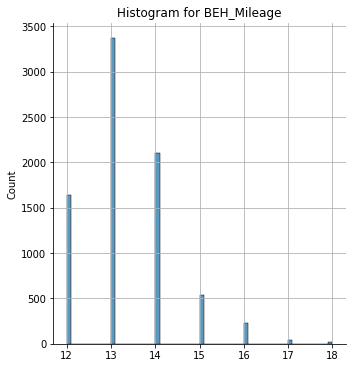

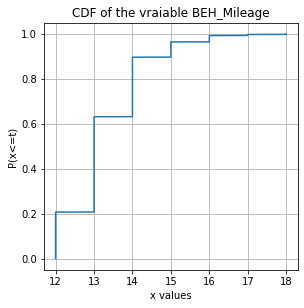

################################################
________________BEH_Number_Year_Insured__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        6.464335
std         3.954401
min        -1.000000
25%         3.000000
50%         7.000000
75%        10.000000
max        10.000000
Name: BEH_Number_Year_Insured, dtype: float64
_________________plots________________


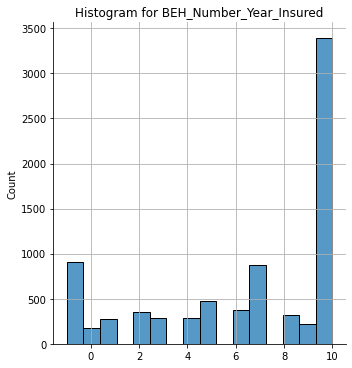

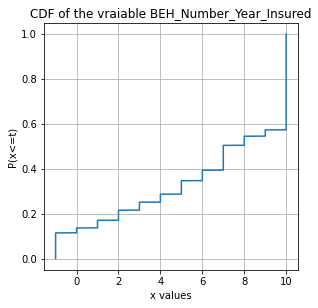

################################################
________________VEH_Number_of_doors__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7365.000000
mean        4.606925
std         0.732115
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: VEH_Number_of_doors, dtype: float64
_________________plots________________


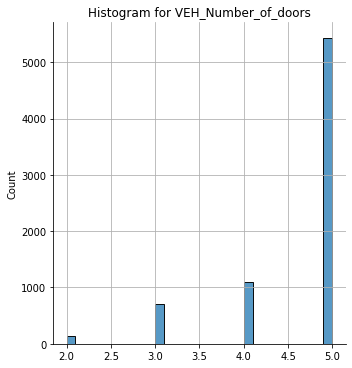

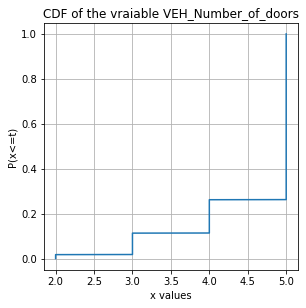

################################################
________________CLA_HISTORY__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        1.525475
std         1.990860
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: CLA_HISTORY, dtype: float64
_________________plots________________


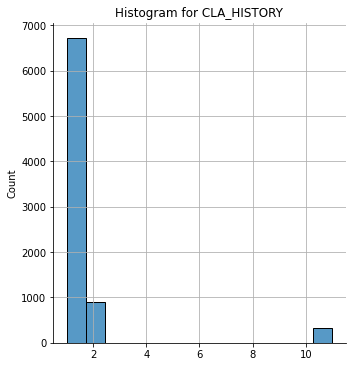

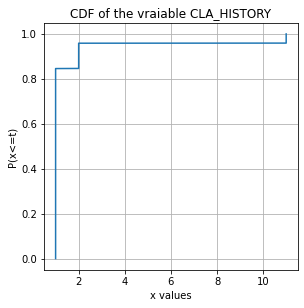

################################################
________________CLA_HISTORY_1Y__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        1.129702
std         0.969287
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: CLA_HISTORY_1Y, dtype: float64
_________________plots________________


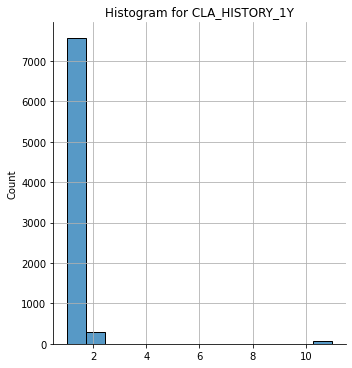

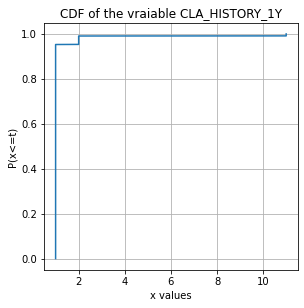

################################################
________________CLA_HISTORY_3Y__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        1.326708
std         1.550952
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: CLA_HISTORY_3Y, dtype: float64
_________________plots________________


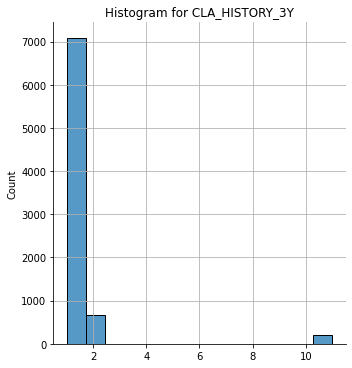

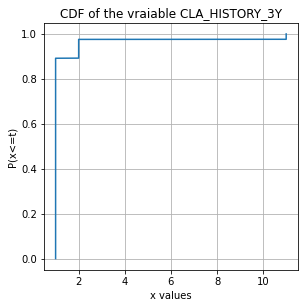

################################################
________________CLA_BM_TPL_DECLARED__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        1.649138
std         2.177296
min        -1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: CLA_BM_TPL_DECLARED, dtype: float64
_________________plots________________


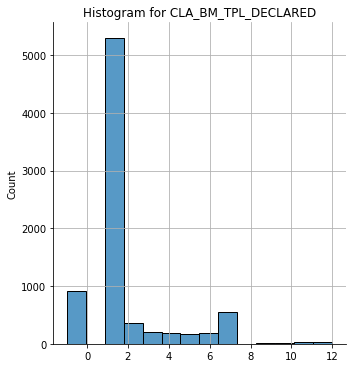

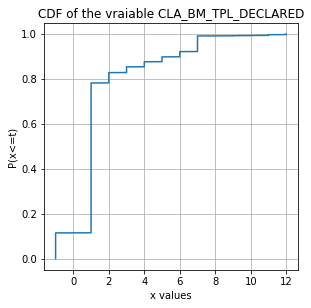

################################################
________________CLA_BM__________________
#################################################
__________________Summary statistics of the response variable__________________
count    7949.000000
mean        6.420304
std         3.763531
min         0.000000
25%         3.000000
50%         7.000000
75%        10.000000
max        10.000000
Name: CLA_BM, dtype: float64
_________________plots________________


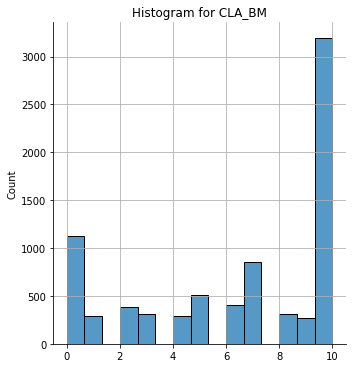

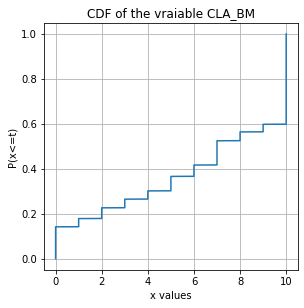

In [23]:
analyzer.is_categorical = True

for element in as_quantitative :

  print('################################################')
  print("________________" + element + "__________________")
  print("#################################################")

  analyzer.get_univariate_statistics(X_train[element])

### Qualitative variables

In [24]:
print('X shape :', X_train[qualitative].shape)

X_train[qualitative].describe(include = [object])

X shape : (7986, 17)


PROD_Formula PER_sex  ... PER_Is_second_driver PER_Insured_Before
count          7986    7986  ...                 7949               7949
unique            2       2  ...                    2                  3
top            FULL       1  ...                    1                  2
freq           5087    6096  ...                 6699               3545

[4 rows x 17 columns]

7942/7986 : are the missing_values the sames???

VEH_Drive_type & VEH_Body : large number of bins, should they be treated as quantitative variables ??

################################################
________________PROD_Formula__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7986
unique       2
top       FULL
freq      5087
Name: PROD_Formula, dtype: object
_________________plots________________


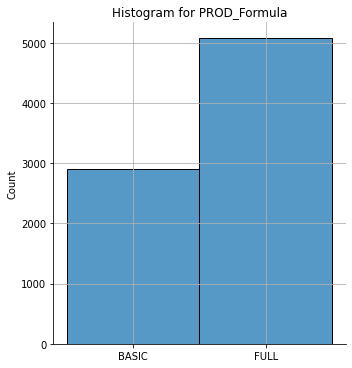

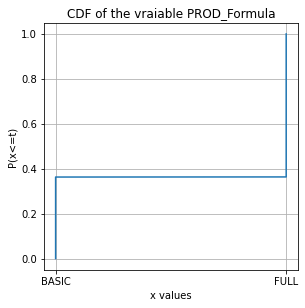

################################################
________________PER_sex__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7986
unique       2
top          1
freq      6096
Name: PER_sex, dtype: object
_________________plots________________


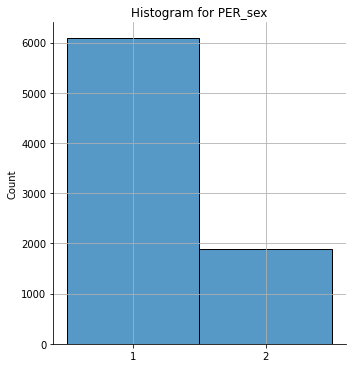

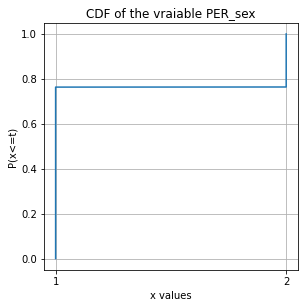

################################################
________________PER_Sex_Second_Driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7986
unique       3
top          0
freq      6728
Name: PER_Sex_Second_Driver, dtype: object
_________________plots________________


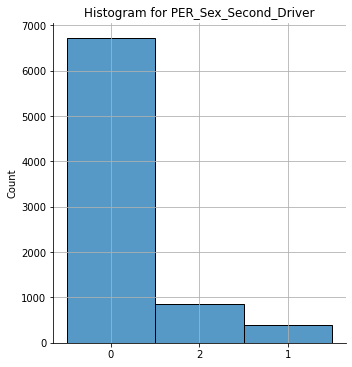

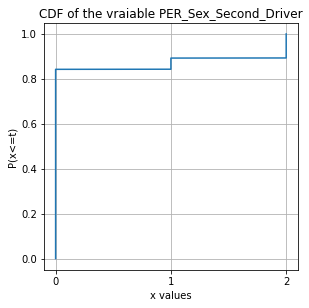

################################################
________________PER_KIDS_ON_BOARD_ID__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       3
top          2
freq      3077
Name: PER_KIDS_ON_BOARD_ID, dtype: object
_________________plots________________


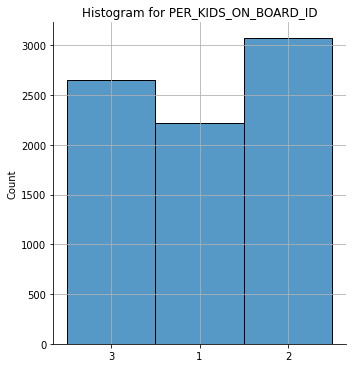

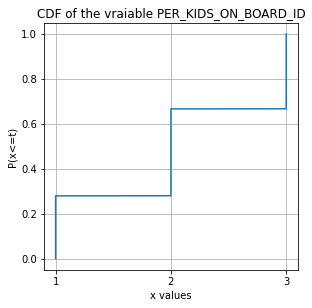

################################################
________________VEH_TransmissionId__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       2
top          7
freq      7259
Name: VEH_TransmissionId, dtype: object
_________________plots________________


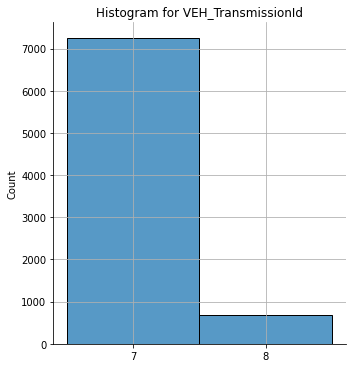

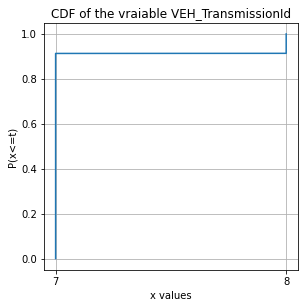

################################################
________________PER_Matrimonial_Status__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7151
unique       4
top          2
freq      4651
Name: PER_Matrimonial_Status, dtype: object
_________________plots________________


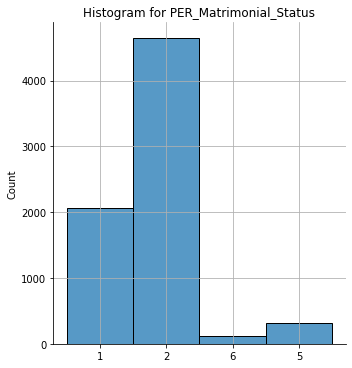

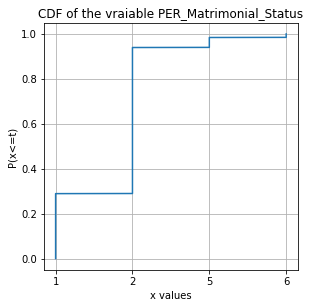

################################################
________________VEH_Injection_Mode__________________
#################################################
__________________Summary statistics of the response variable__________________
count       5924
unique         5
top       389999
freq        2979
Name: VEH_Injection_Mode, dtype: object
_________________plots________________


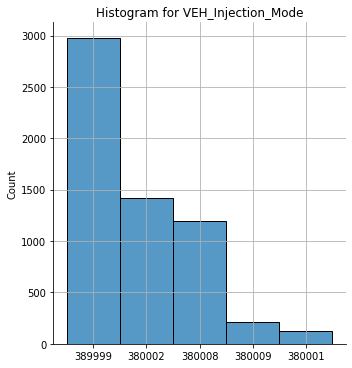

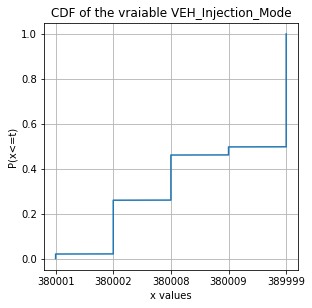

################################################
________________VEH_fuel_type__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       2
top          1
freq      4408
Name: VEH_fuel_type, dtype: object
_________________plots________________


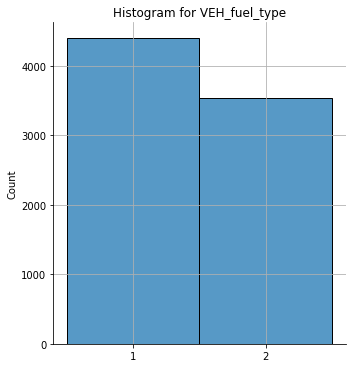

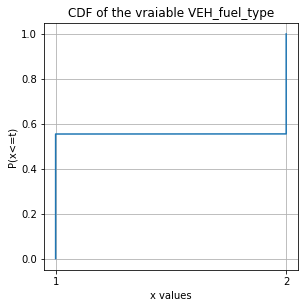

################################################
________________BEH_vehicule_usage__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       1
top          1
freq      7949
Name: BEH_vehicule_usage, dtype: object
_________________plots________________


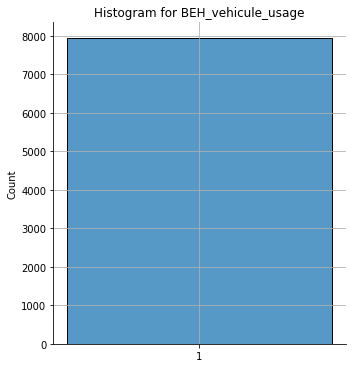

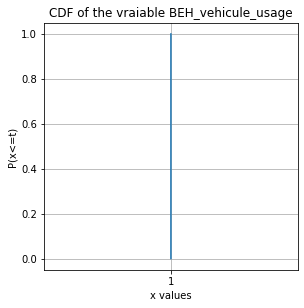

################################################
________________VEH_Drive_type__________________
#################################################
__________________Summary statistics of the response variable__________________
count      7949
unique        8
top       50001
freq       6869
Name: VEH_Drive_type, dtype: object
_________________plots________________


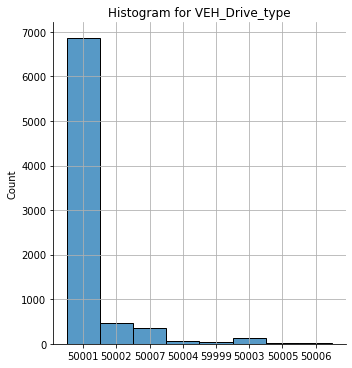

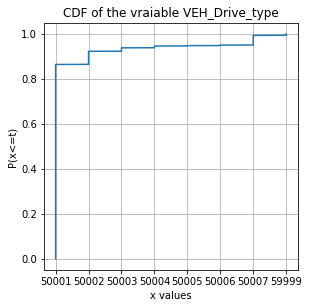

################################################
________________VEH_Body__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique      11
top         10
freq      3852
Name: VEH_Body, dtype: object
_________________plots________________


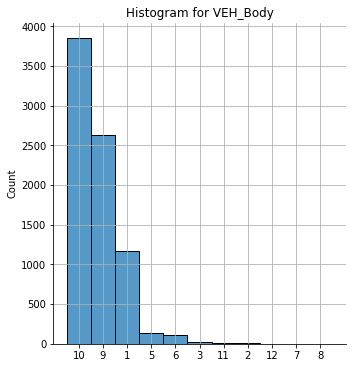

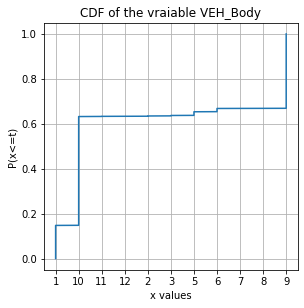

################################################
________________VEH_Segment__________________
#################################################
__________________Summary statistics of the response variable__________________
count      7949
unique        8
top       30003
freq       3374
Name: VEH_Segment, dtype: object
_________________plots________________


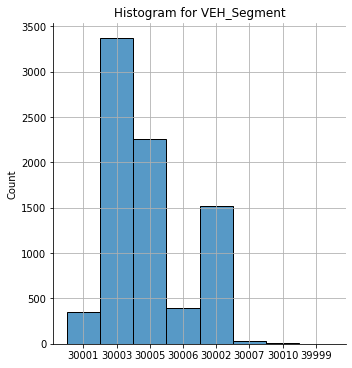

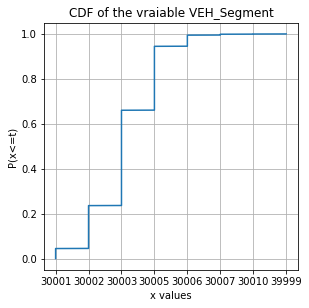

################################################
________________PER_Parking_Type__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       4
top          2
freq      4590
Name: PER_Parking_Type, dtype: object
_________________plots________________


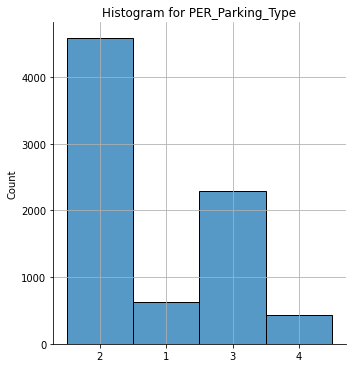

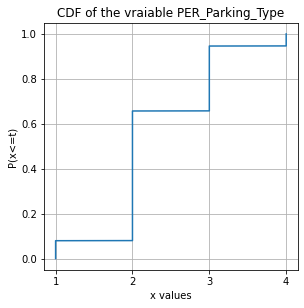

################################################
________________VEH_High_Risk_Vehicle__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       2
top          2
freq      7265
Name: VEH_High_Risk_Vehicle, dtype: object
_________________plots________________


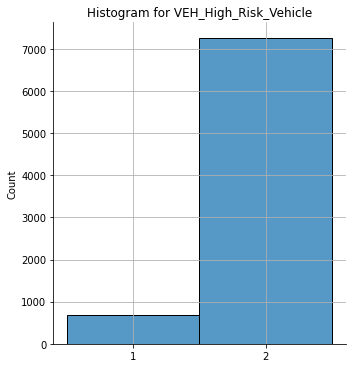

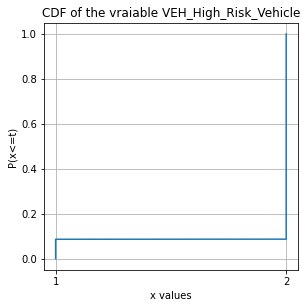

################################################
________________PER_previous_insurer__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique      15
top         27
freq      1547
Name: PER_previous_insurer, dtype: object
_________________plots________________


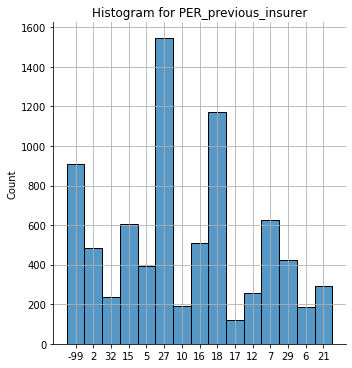

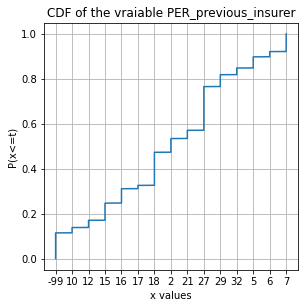

################################################
________________PER_Is_second_driver__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       2
top          1
freq      6699
Name: PER_Is_second_driver, dtype: object
_________________plots________________


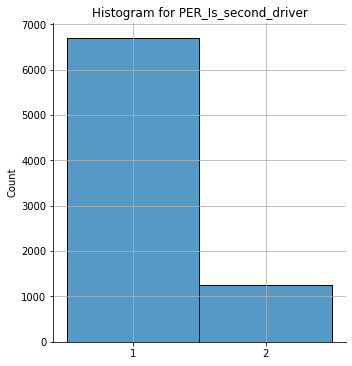

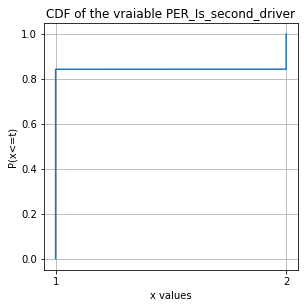

################################################
________________PER_Insured_Before__________________
#################################################
__________________Summary statistics of the response variable__________________
count     7949
unique       3
top          2
freq      3545
Name: PER_Insured_Before, dtype: object
_________________plots________________


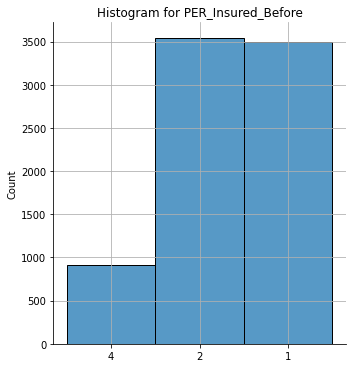

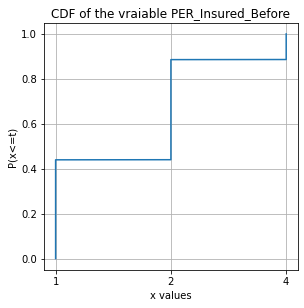

In [25]:
for element in qualitative :

  analyzer.is_categorical = True

  print('################################################')
  print("________________" + element + "__________________")
  print("#################################################")

  analyzer.get_univariate_statistics(X_train[element])
 

- **PROD_Formula** no missing values, FULL/BASIC to encode as 0/1
- **PER_sex** no missing values, 1/2 to encode as 0/1
- **PER_Sex_Second_Driver** no NA, missing values encoded by 0 (if the default encoding for M/W is the same as before). To replace by flag second driver 0/1 and is_man_second_driver 0/1 (get dummies at least). The 0s mean that there is no 2nd driver.
- **PER_KIDS_ON_BOARD_ID** 7945/7986 values. 1/2/3 we must get dummies.
- **VEH_TransmissionId**  7945/7986 values : 7/8 :  to encode as 0/1
- **PER_Matrimonial_Status** 7151/7986 values. 1/2/5/6 we must get dummies.
- **VEH_Injection_Mode** 5930/7986 values. Arbitrary encoding : we need to get dummies.
- **VEH_fuel_type** 7945/7986 values. 1/2 to encode as 0/1
- **BEH_vehicule_usage** 7945/7948 : 1 unique modality. To delete (it can't be discriminant for the response variable).
- **VEH_Drive_type** 7945/7986 values. 8 modalities, it could maybe be treated as a quantitative variable, however the variable name tells us that it is a type of vehicle so that there is no distance between its values. We will get dummies.
- **VEH_Body** 7945/7986. 10 modalities. Same reflexion as VEH_Drive_Type.
- **VEH_Segment** 7945/7986. 8 modalities. Same reflexion as VEH_Drive_Type. We must check for lienar independance between VEH_Segment and VEH_Drive_Type.
- **PER_Parking_Type** 7945/7986. 1/2/3/4, we will get dummies.
- **VEH_High_Risk_Vehicle** 7945/7986. 1/2 -> 0/1
- **PER_previous_insurer** 7945/7986. 15 modalities -> get dummies
- **PER_Is_second_driver** 7945/7986. 1/2 -> 0/1
- **PER_Insured_Before** 7945/7986. insured before 1/2/4 -> get dummies (but beware of value 3!!! in test sets).

We will really have to check if the missing values are the sames!

Most of cdfs have no sense here.

### Geographical data

In [72]:
geo_data = pd.DataFrame( (X_train['GEO_Long'], X_train['GEO_Lat'], y_train) ).transpose()
geo_data.head()

GEO_Long   GEO_Lat  Response_Market_Index
9499 -0.747747  0.475824                  743.0
1314  0.018853 -1.440876                  259.0
9970 -2.114447  0.609124                  309.0
5596  1.985553  0.509124                  391.0
5204  0.368853  2.425824                  426.0

In [73]:
import plotly.express as px

fig = px.scatter_mapbox(geo_data, lat="GEO_Lat", lon="GEO_Long", hover_data=["Response_Market_Index"],
                        color_discrete_sequence=y_train, zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

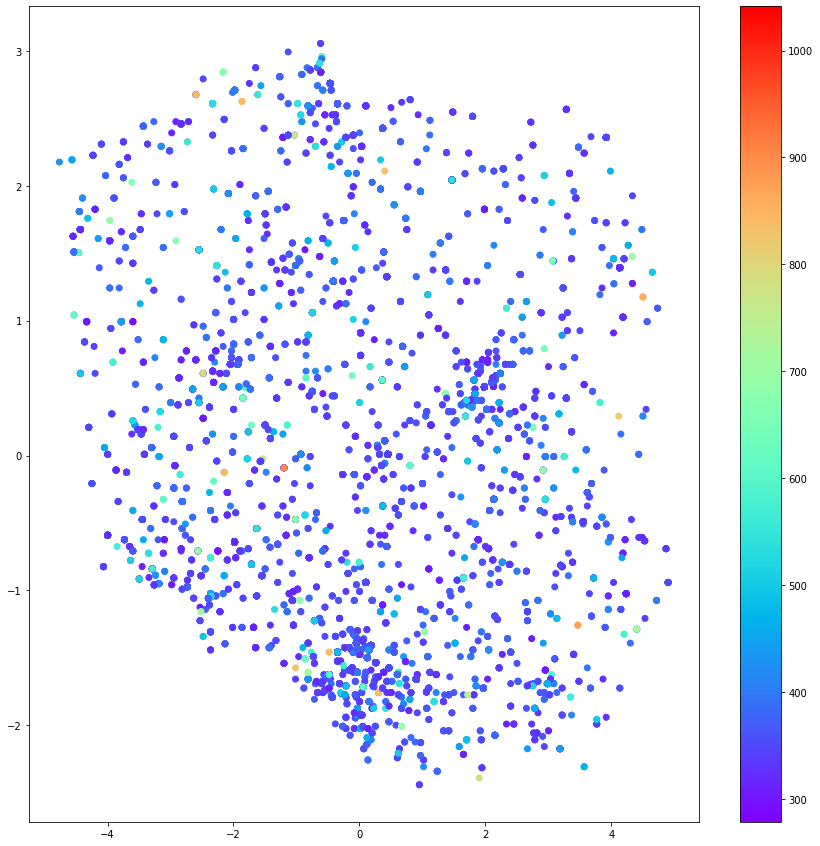

In [74]:
norm = matplotlib.colors.Normalize(vmin = quantile(y_train, 0.05), vmax = quantile(y_train, 0.95))
cmap = cm.rainbow
sm = cm.ScalarMappable(cmap = cmap, norm = norm)

fig = figure(figsize = (15,15))
scatter(X_train['GEO_Long'], X_train['GEO_Lat'], c = y_train, cmap = cmap)
fig.colorbar(sm)

## 2. Multivariate analysis


### Correlations between features

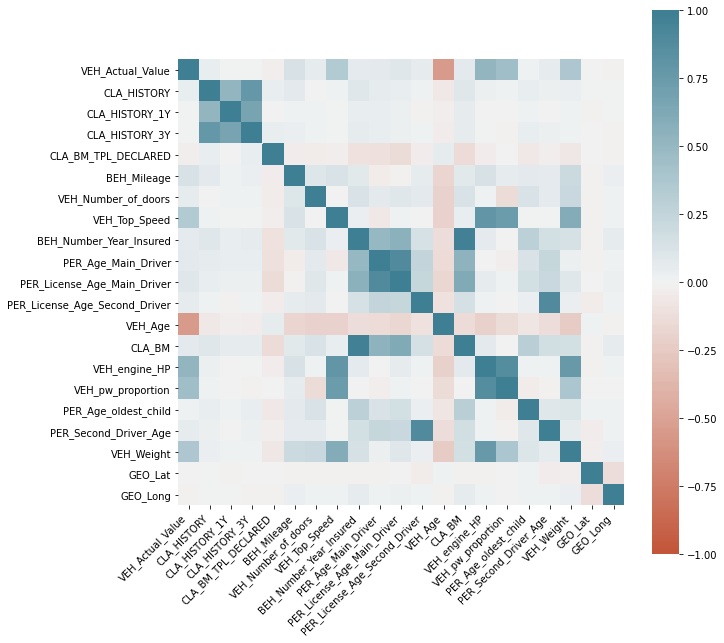

In [ ]:
corr = X_train.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
figsize(20, 20)
show(ax)

**Strong correlations**

- CLA_HISTORY_1Y / CLA_HISTORY_2Y / CLA_HISTORY_3Y

- VEH_VALUE with VEH_ACTUAL_VALUE (value decreases wwith age in general), VEH_engine_hp, VEH_pw_proportion, VEH_weight

- VEH_TOP_SPEED with VEH_engine_hp, VEH_pw_proportion (speed depends on these ok), VEH_weight

- BEH_NUMBER_YEAR_INSURED / PER_MAIN_AGE_DRIVER / PER_LICENCE_AGE_MAIN_DRIVER / CLA_BM

- PER_LICENCE_SECOND_MAIN_DRIVER / PER_SECOND_DRIVER_AGE ok

### Correlation features/response

**Fast visualization**

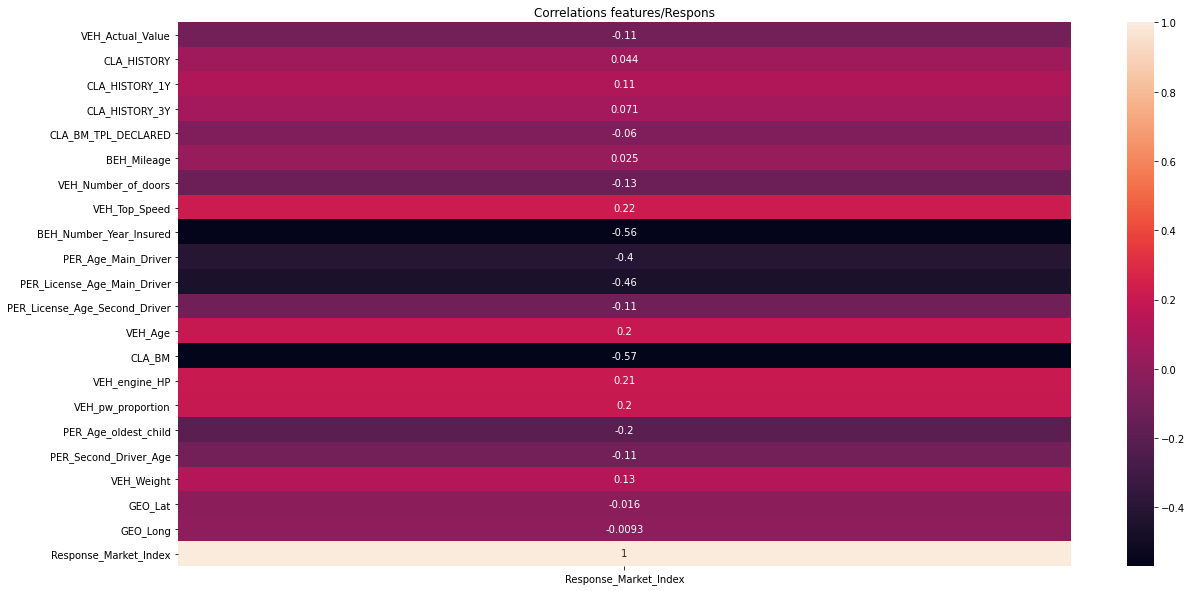

In [ ]:
Xy_train = X_train.copy()
Xy_train['Response_Market_Index'] = y_train
corrMatrix = pd.DataFrame(Xy_train.corr(method = 'spearman'))
figsize(20,10)
sns.heatmap(corrMatrix[['Response_Market_Index']], annot=True)
title('Correlations features/Respons')
show()

In [ ]:
class Custom_multivariate_analysis():

  def __init__(self, full_quantitative = quantitative + geographical + as_quantitative, full_qualitative = qualitative):
    self.quantitative = full_quantitative.copy()
    self.qualitative = full_qualitative.copy()

  def quick_visualization(self, X, y):
    Xy = X.copy()
    name = y.name
    Xy[name] = y
    corrMatrix = pd.DataFrame(Xy_train.corr(method = 'spearman'))
    figsize(20,10)
    sns.heatmap(corrMatrix[[name]], annot=True)
    title('Correlations features/Respons')
    show()





  def quantitative_vs_response(self, X, y):
    quantitative = self.quantitative
    name = y.name
    
    for variable in quantitative:
      Xy = pd.DataFrame( (X[variable], y) ).transpose()

      print("#############Response vs " + variable + "##############")

      print("_______________Smooth Scatter Plot______________")
      
      figsize(10, 10)
      ax = sns.displot(Xy, 
                  x = variable, 
                  y = name)
      show()

      print("_______________Smooth joint Distribution______________")
      figsize(10, 10)
      sns.kdeplot(data = Xy, 
                  x = variable, 
                  y = name, 
                  fill=True, 
                  thresh=0, 
                  levels=100, 
                  cmap="mako")
      show()

      print("______________Spearman's correlation tests______________")
      test = scipy.stats.spearmanr(Xy[variable], Xy[name], nan_policy = 'omit')
      print('Value: ', test[0])
      print("p-value: ", test[1])






  def qualitative_vs_response(self, X, y):
    qualitative = self.qualitative
    name = y.name

    for variable in qualitative: 
      
      Xy = pd.DataFrame( (X[variable], y) ).transpose()

      print("#############Response vs " + variable + "##############")

      print("_____________Pivot_______________")
      figsize = (10, 10)
      # Plot the orbital period with horizontal boxes
      sns.boxplot(x = name, 
                  y = variable, 
                  data=Xy,
                  whis=[0, 100], 
                  width=.6, 
                  palette="vlag")

      # Add in points to show each observation
      sns.stripplot(x = name, 
                    y = variable, 
                    data=Xy,
                    size=4, 
                    color=".3", 
                    linewidth=0)
      show()

      print("______________Conditionnal Distribution_______________")
      figsize = (10, 10)
      try : 
        Xy[variable] = Label_Encoder().fit_transform(Xy[variable])
        sns.displot(x = name, hue = variable, data = Xy, kde = True, fill = True)
        show()
      except : 
        sns.displot(Xy, x = name, hue = variable, fill = True)
        show()
      
      
      print('_____________Kruskal-Wallis adequacy tests_______________')
      categories = unique(Xy[variable].dropna())
      y_knowing_x = []
      for category in categories : 
        y_knowing_x.append(Xy.loc[ Xy[variable] == category ][name])
      try :
        test = scipy.stats.kruskal(*y_knowing_x)
      except :
        print("No possible test for ", variable)
        pass
      print('Value: ', test[0])
      print("p-value: ", test[1])


  def get_multivariate_analysis(self, X, y):

    print("################################################")
    print("#########Quantitative vs quantitative###########")
    print("################################################")

    self.quantitative_vs_response(X, y)

    print('')
    print('')

    print("################################################")
    print("#########Quantitative vs qualitative############")
    print("################################################")

    self.qualitative_vs_response(X, y)

################################################
#########Quantitative vs quantitative###########
################################################
#############Response vs VEH_Actual_Value##############
_______________Smooth Scatter Plot______________


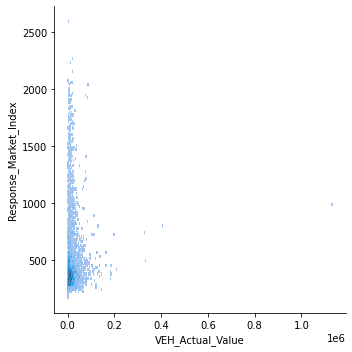

_______________Smooth joint Distribution______________


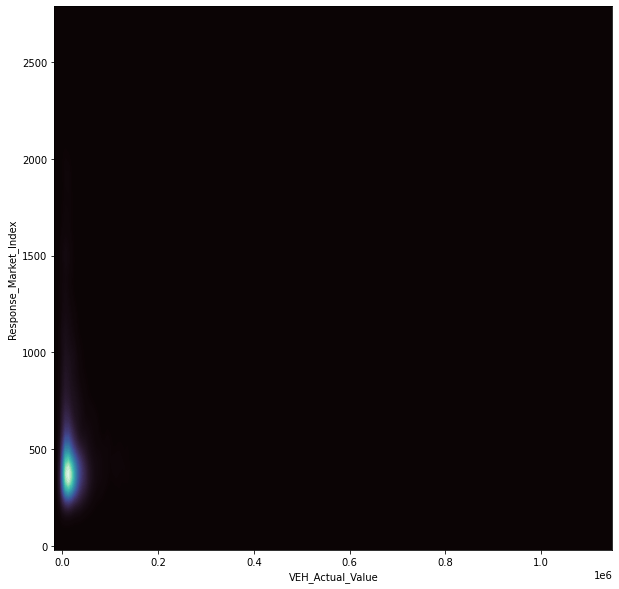

______________Spearman's correlation tests______________
Value:  -0.09065535940439727
p-value:  4.785861127203082e-16
#############Response vs VEH_Top_Speed##############
_______________Smooth Scatter Plot______________


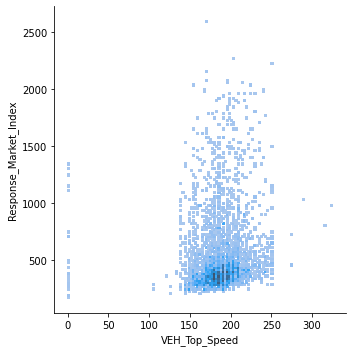

_______________Smooth joint Distribution______________


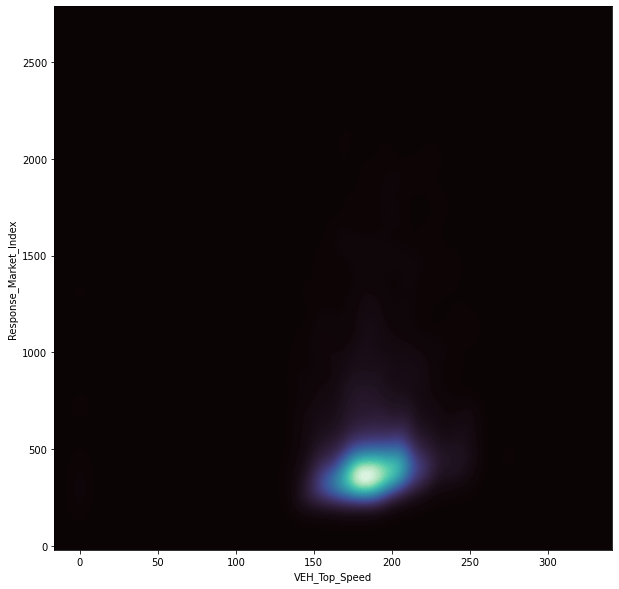

______________Spearman's correlation tests______________
Value:  0.23095940598054232
p-value:  9.51182037584888e-97
#############Response vs PER_Age_Main_Driver##############
_______________Smooth Scatter Plot______________


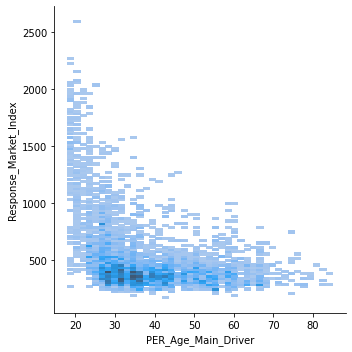

_______________Smooth joint Distribution______________


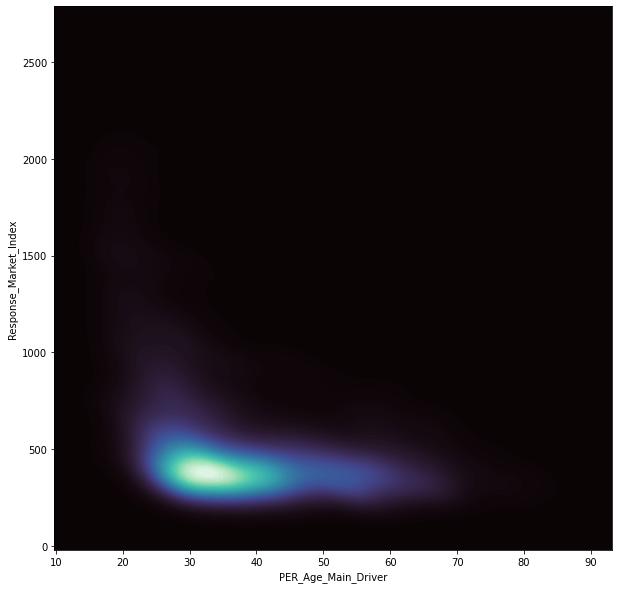

______________Spearman's correlation tests______________
Value:  -0.4139713896242005
p-value:  0.0
#############Response vs PER_License_Age_Main_Driver##############
_______________Smooth Scatter Plot______________


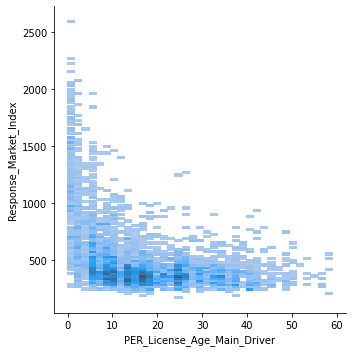

_______________Smooth joint Distribution______________


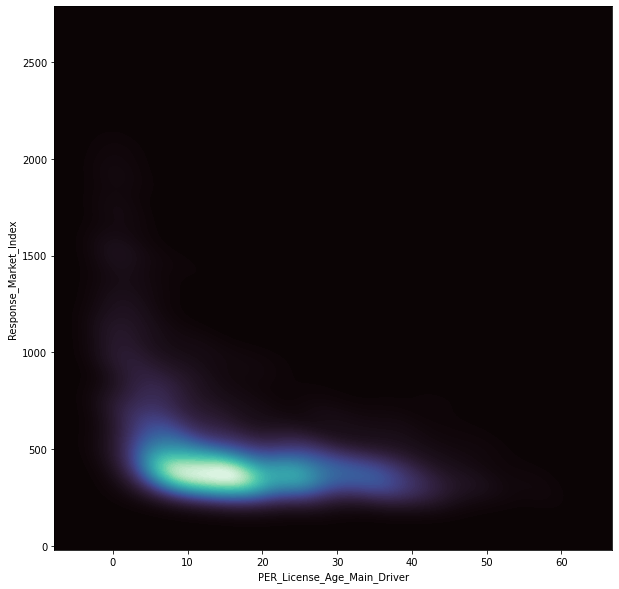

______________Spearman's correlation tests______________
Value:  -0.461438450921967
p-value:  0.0
#############Response vs PER_License_Age_Second_Driver##############
_______________Smooth Scatter Plot______________


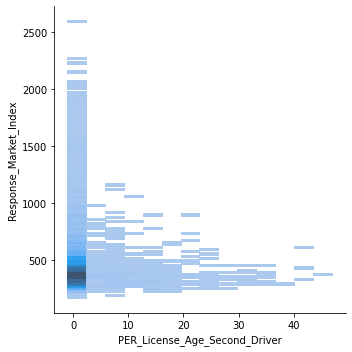

_______________Smooth joint Distribution______________


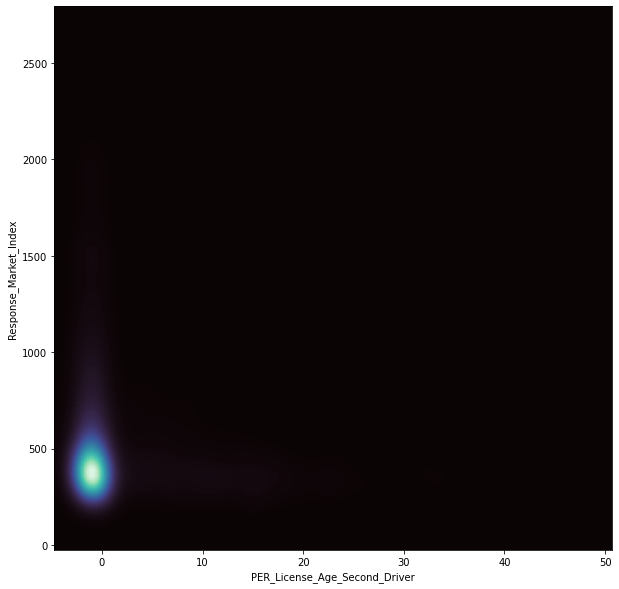

______________Spearman's correlation tests______________
Value:  -0.11149106032068899
p-value:  3.3254780756042085e-21
#############Response vs VEH_Age##############
_______________Smooth Scatter Plot______________


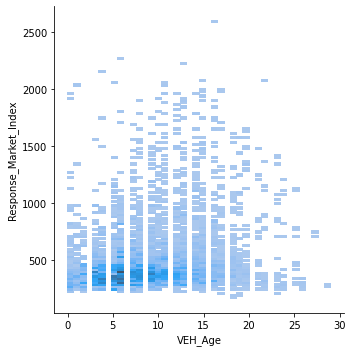

_______________Smooth joint Distribution______________


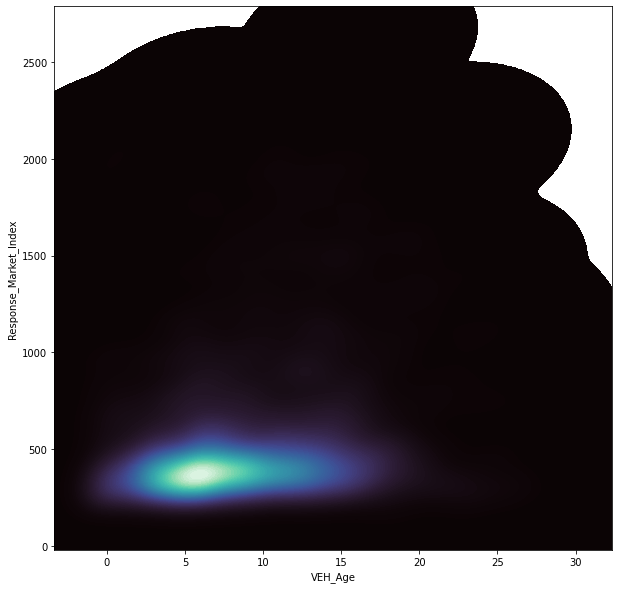

______________Spearman's correlation tests______________
Value:  0.18885620064820222
p-value:  9.840438795750281e-65
#############Response vs VEH_engine_HP##############
_______________Smooth Scatter Plot______________


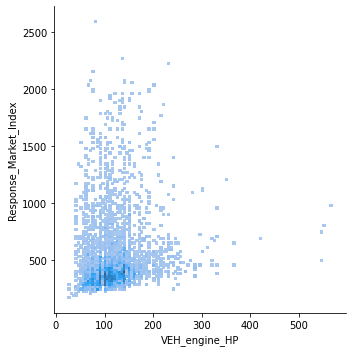

_______________Smooth joint Distribution______________


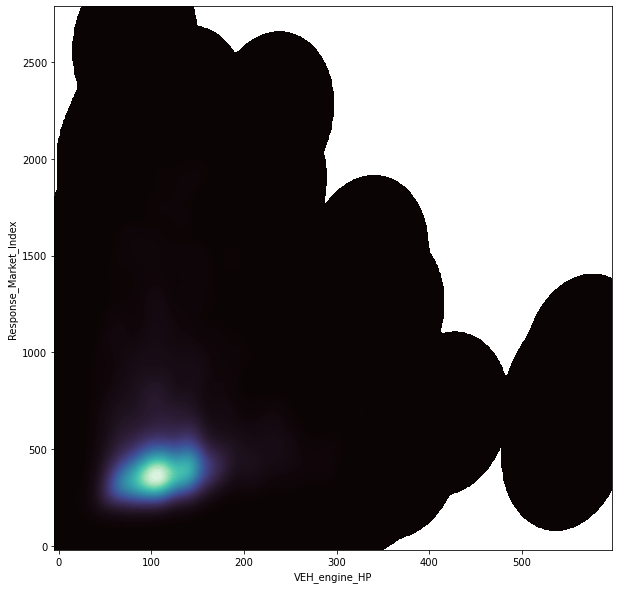

______________Spearman's correlation tests______________
Value:  0.2200293260390523
p-value:  9.178328458471083e-88
#############Response vs VEH_pw_proportion##############
_______________Smooth Scatter Plot______________


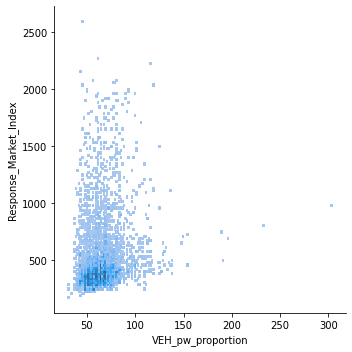

_______________Smooth joint Distribution______________


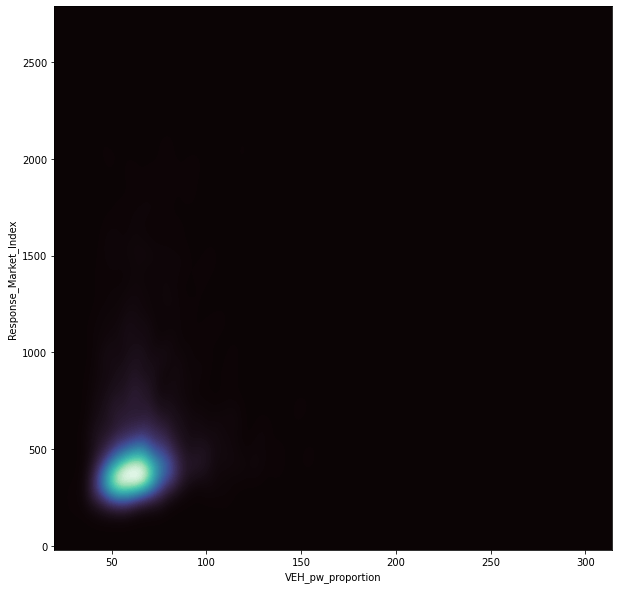

______________Spearman's correlation tests______________
Value:  0.21692755619234838
p-value:  2.662672091878887e-85
#############Response vs PER_Age_oldest_child##############
_______________Smooth Scatter Plot______________


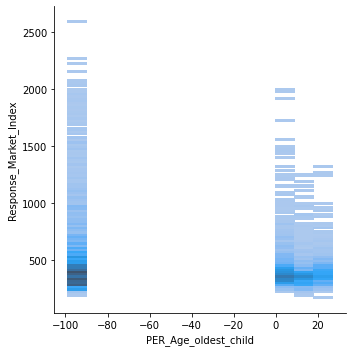

_______________Smooth joint Distribution______________


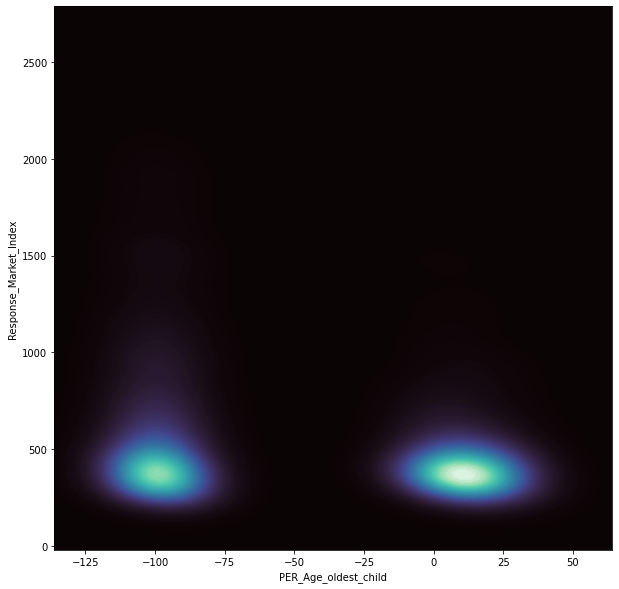

______________Spearman's correlation tests______________
Value:  -0.19538405568218167
p-value:  3.0438051746456517e-69
#############Response vs PER_Second_Driver_Age##############
_______________Smooth Scatter Plot______________


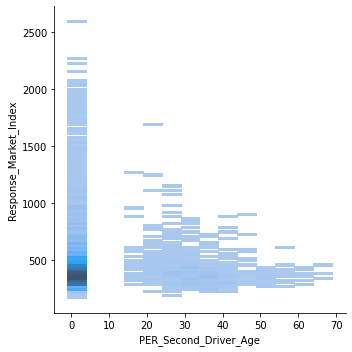

_______________Smooth joint Distribution______________


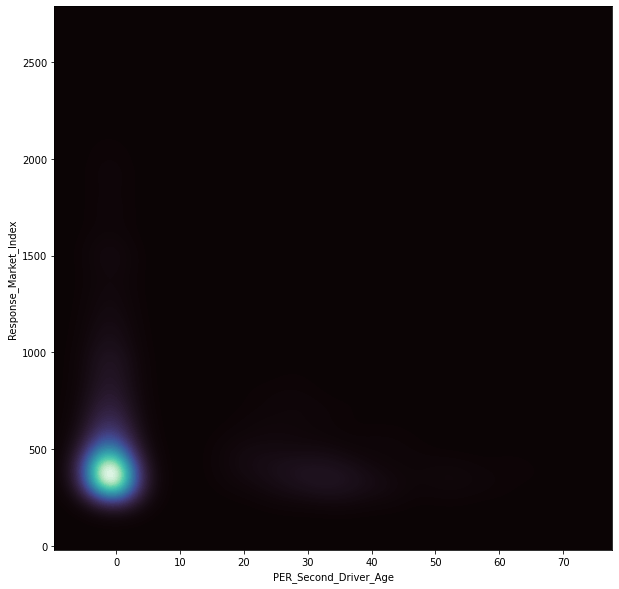

______________Spearman's correlation tests______________
Value:  -0.10718681411279354
p-value:  9.409367349114783e-22
#############Response vs VEH_Weight##############
_______________Smooth Scatter Plot______________


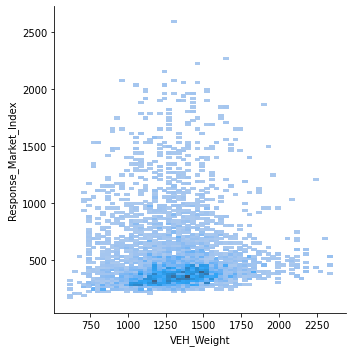

_______________Smooth joint Distribution______________


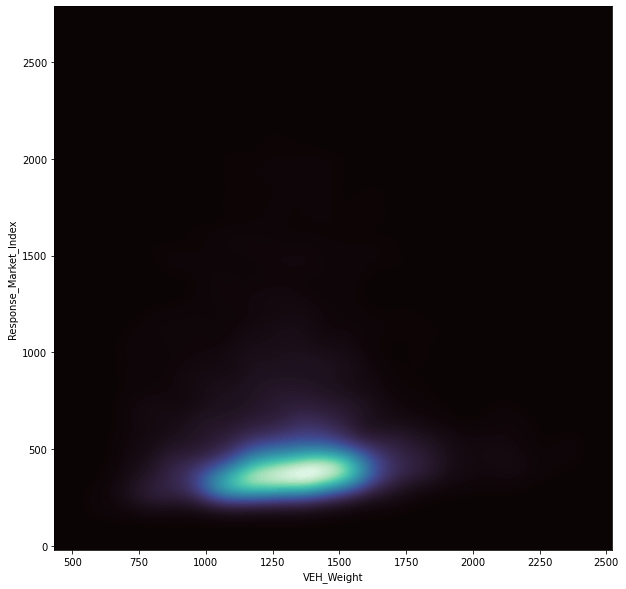

______________Spearman's correlation tests______________
Value:  0.14393722887745306
p-value:  4.5571745674321587e-38
#############Response vs GEO_Lat##############
_______________Smooth Scatter Plot______________


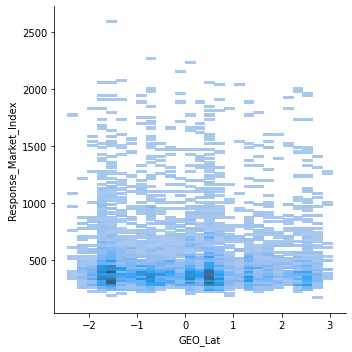

_______________Smooth joint Distribution______________


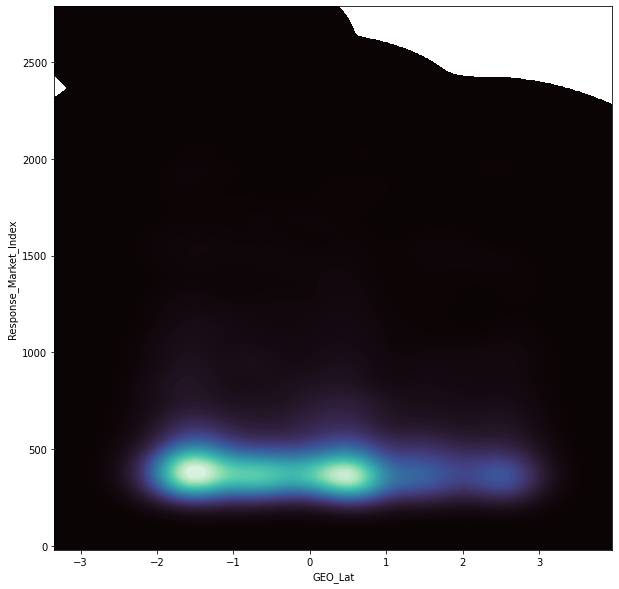

______________Spearman's correlation tests______________
Value:  -0.030369989029517645
p-value:  0.006643650096490174
#############Response vs GEO_Long##############
_______________Smooth Scatter Plot______________


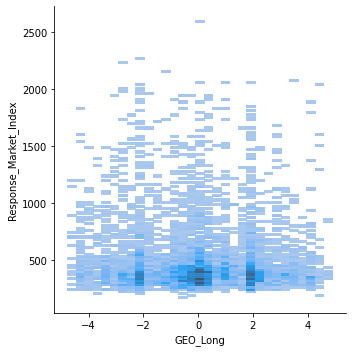

_______________Smooth joint Distribution______________


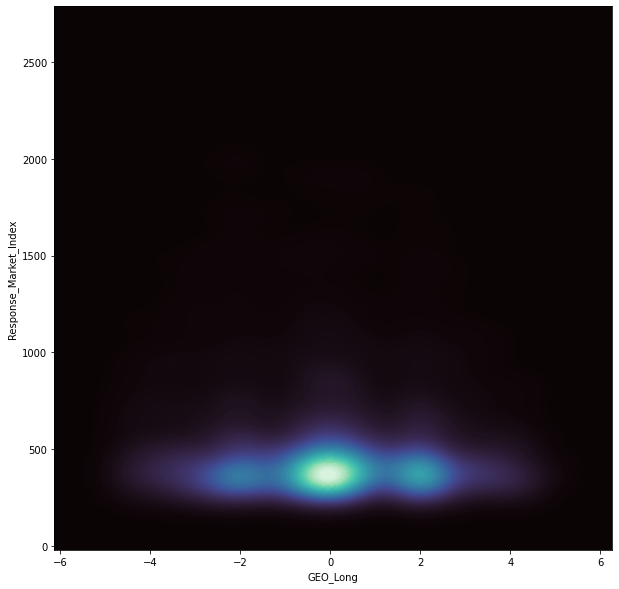

______________Spearman's correlation tests______________
Value:  -0.016077981174730333
p-value:  0.15081250938293433
#############Response vs BEH_Mileage##############
_______________Smooth Scatter Plot______________


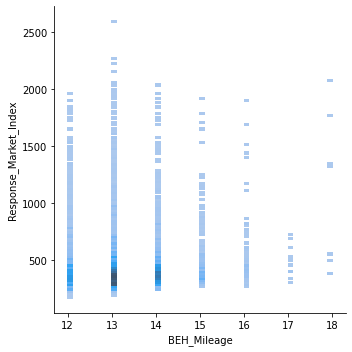

_______________Smooth joint Distribution______________


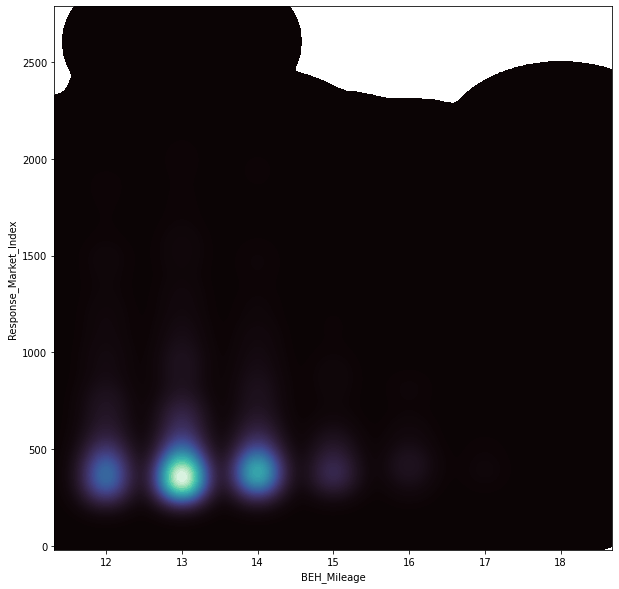

______________Spearman's correlation tests______________
Value:  0.03425424947547574
p-value:  0.002253458806557047
#############Response vs BEH_Number_Year_Insured##############
_______________Smooth Scatter Plot______________


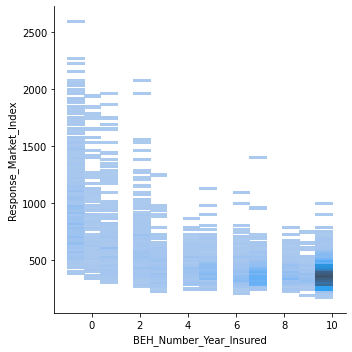

_______________Smooth joint Distribution______________


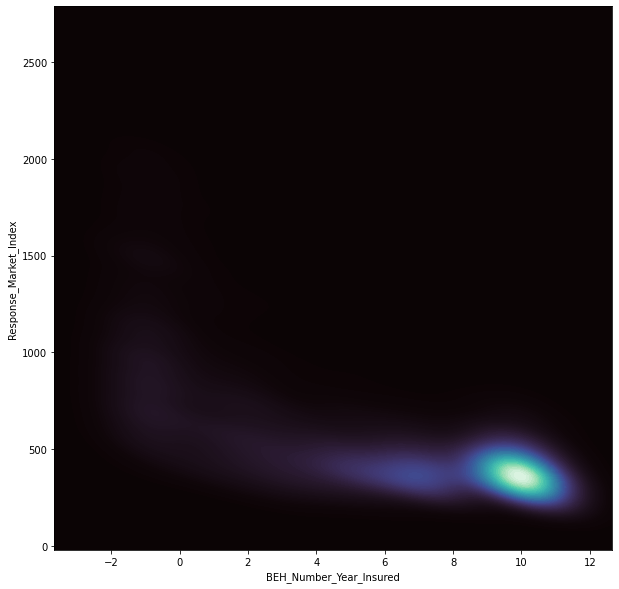

______________Spearman's correlation tests______________
Value:  -0.5662581671953216
p-value:  0.0
#############Response vs VEH_Number_of_doors##############
_______________Smooth Scatter Plot______________


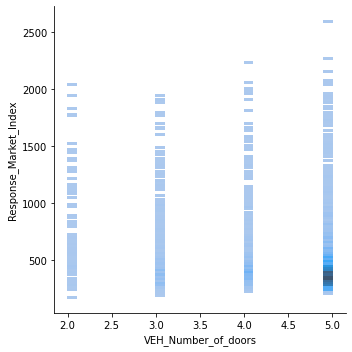

_______________Smooth joint Distribution______________


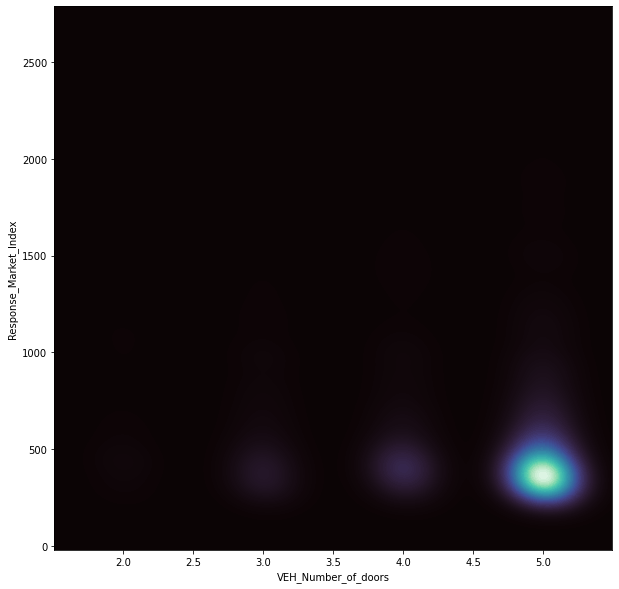

______________Spearman's correlation tests______________
Value:  -0.13524616015579338
p-value:  2.0219677752465486e-31
#############Response vs CLA_HISTORY##############
_______________Smooth Scatter Plot______________


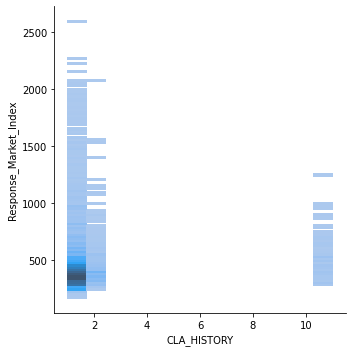

_______________Smooth joint Distribution______________


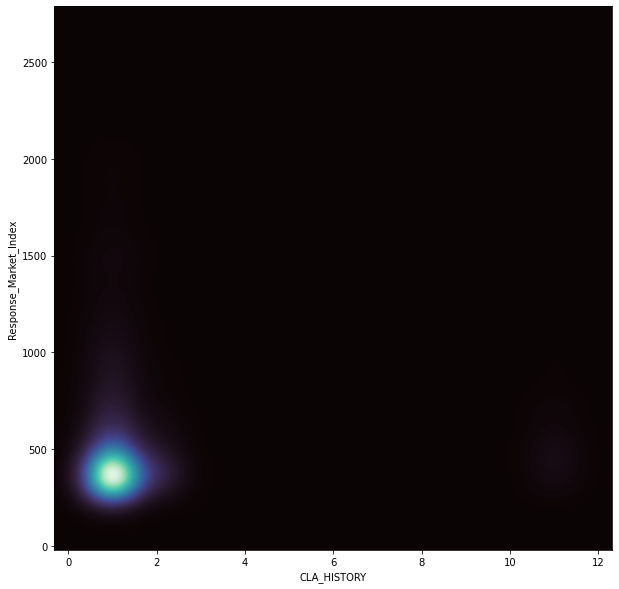

______________Spearman's correlation tests______________
Value:  0.03767388489885976
p-value:  0.0007800668385482517
#############Response vs CLA_HISTORY_1Y##############
_______________Smooth Scatter Plot______________


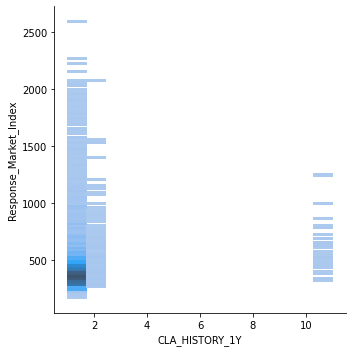

_______________Smooth joint Distribution______________


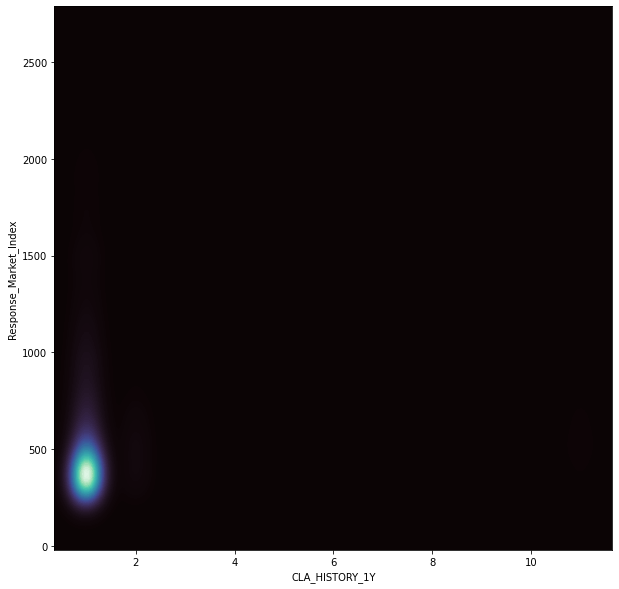

______________Spearman's correlation tests______________
Value:  0.10747195225871599
p-value:  7.337742874616813e-22
#############Response vs CLA_HISTORY_3Y##############
_______________Smooth Scatter Plot______________


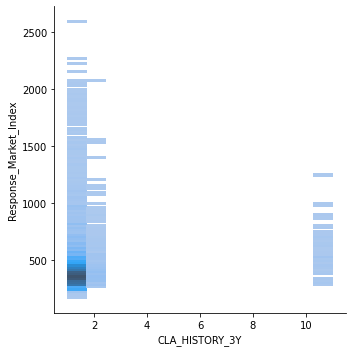

_______________Smooth joint Distribution______________


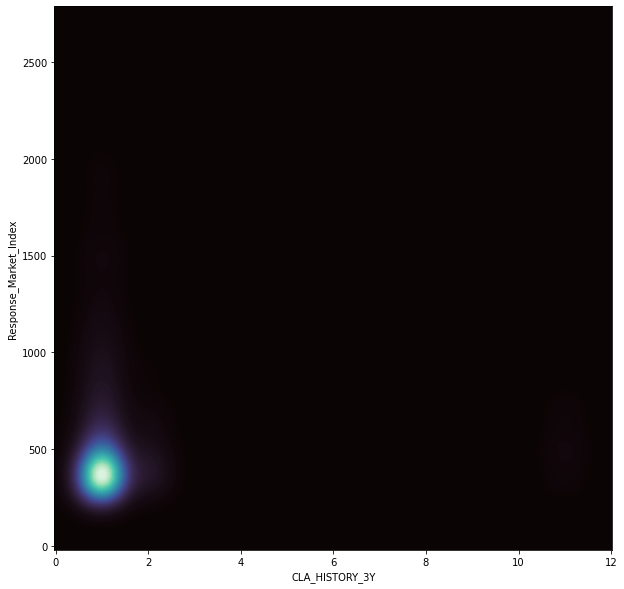

______________Spearman's correlation tests______________
Value:  0.0678254855964719
p-value:  1.417066780256787e-09
#############Response vs CLA_BM_TPL_DECLARED##############
_______________Smooth Scatter Plot______________


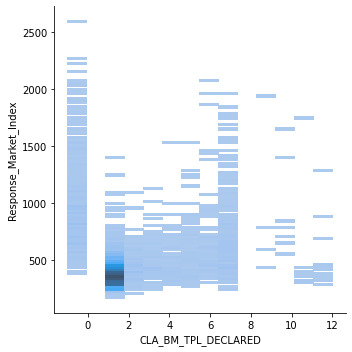

_______________Smooth joint Distribution______________


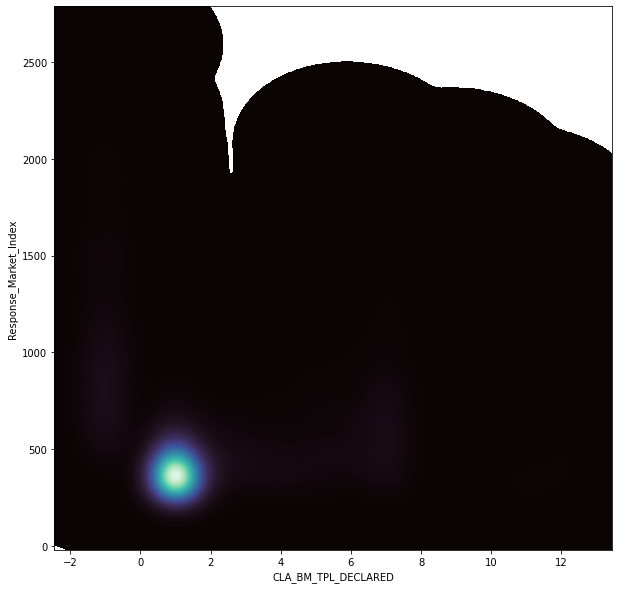

______________Spearman's correlation tests______________
Value:  -0.06432227189947816
p-value:  9.456769233861478e-09
#############Response vs CLA_BM##############
_______________Smooth Scatter Plot______________


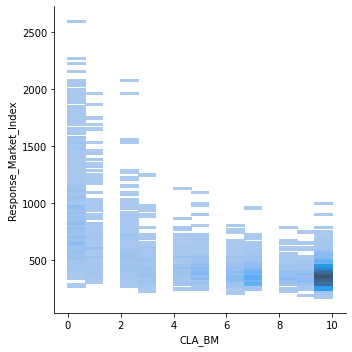

_______________Smooth joint Distribution______________


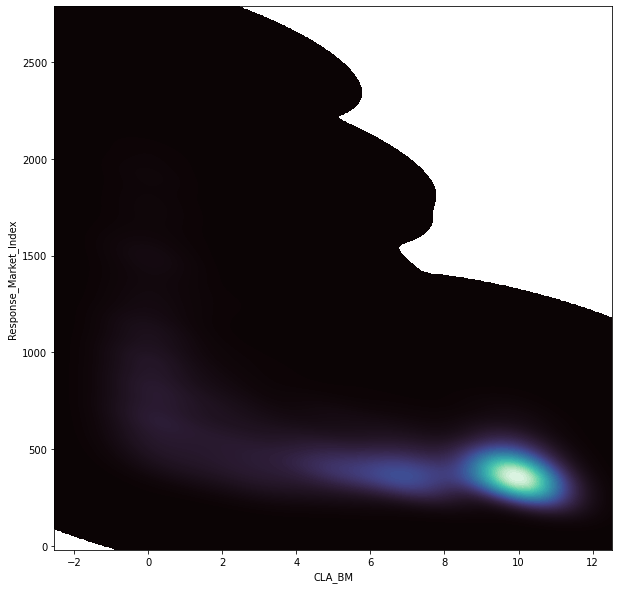

______________Spearman's correlation tests______________
Value:  -0.5745042051070768
p-value:  0.0


################################################
#########Quantitative vs qualitative############
################################################
#############Response vs PROD_Formula##############
_____________Pivot_______________


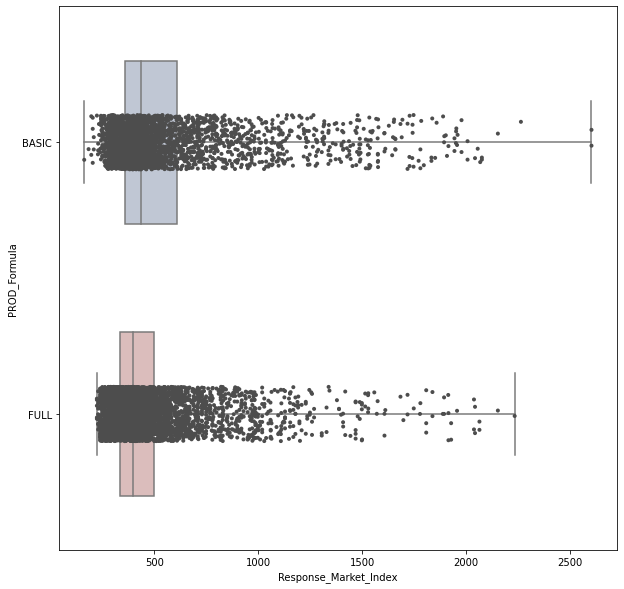

______________Conditionnal Distribution_______________


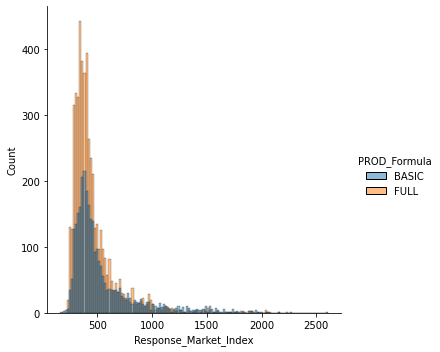

_____________Kruskal-Wallis adequacy tests_______________
Value:  173.16191933412168
p-value:  1.508717881033441e-39
#############Response vs PER_sex##############
_____________Pivot_______________


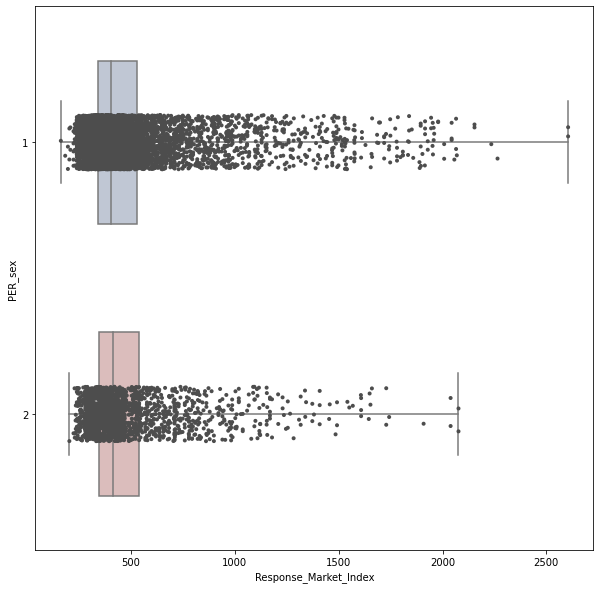

______________Conditionnal Distribution_______________


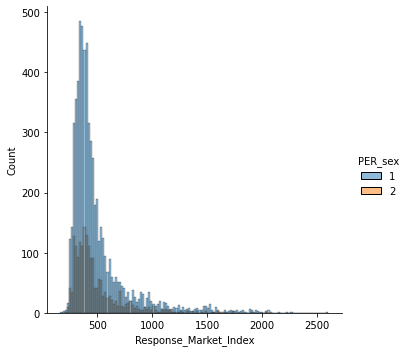

_____________Kruskal-Wallis adequacy tests_______________
Value:  2.8726024644703787
p-value:  0.09009906886778199
#############Response vs PER_Sex_Second_Driver##############
_____________Pivot_______________


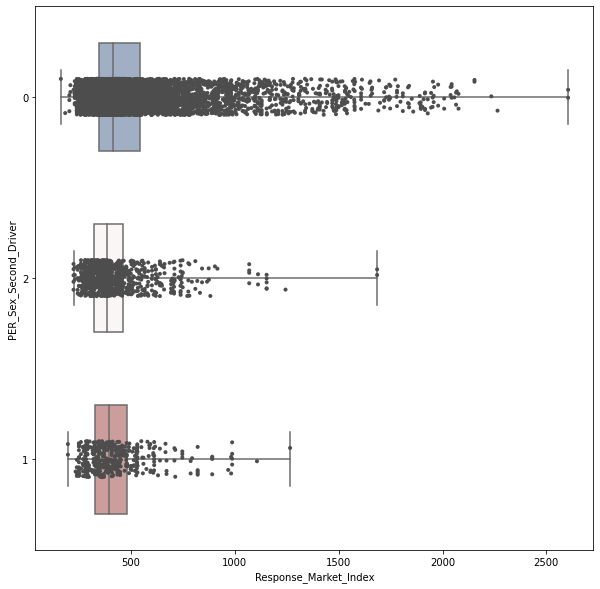

______________Conditionnal Distribution_______________


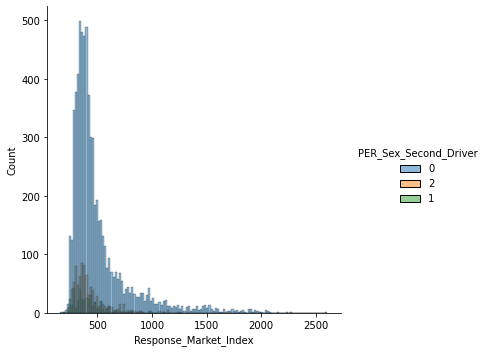

_____________Kruskal-Wallis adequacy tests_______________
Value:  73.35999533166861
p-value:  1.1751124228852154e-16
#############Response vs PER_KIDS_ON_BOARD_ID##############
_____________Pivot_______________


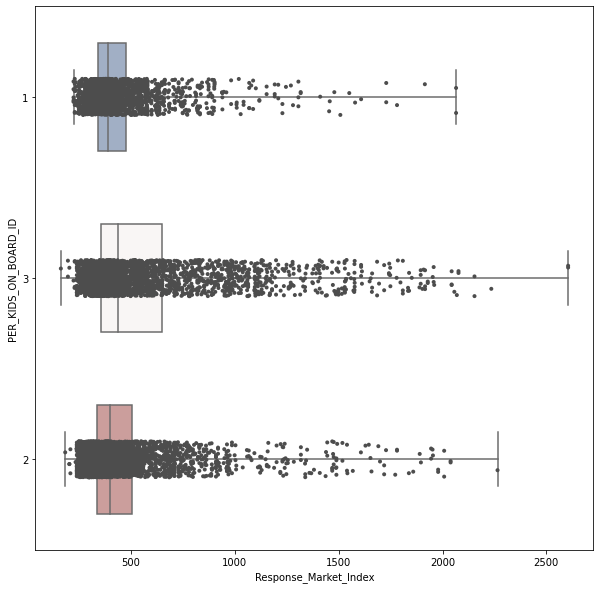

______________Conditionnal Distribution_______________


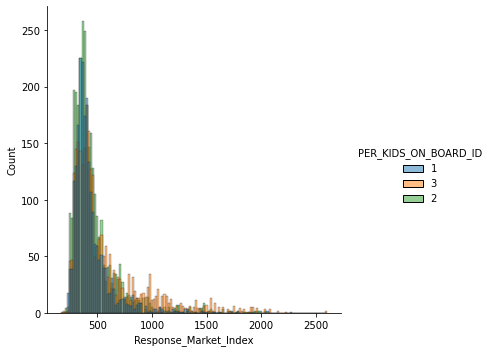

_____________Kruskal-Wallis adequacy tests_______________
Value:  225.99994461528985
p-value:  8.408829981885072e-50
#############Response vs VEH_TransmissionId##############
_____________Pivot_______________


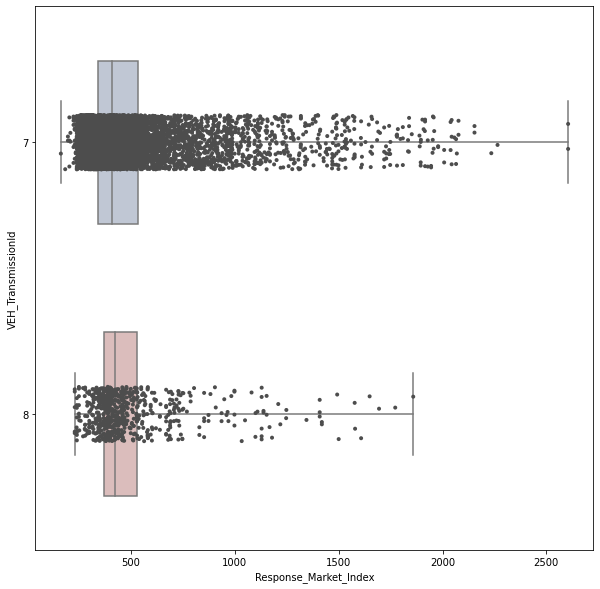

______________Conditionnal Distribution_______________


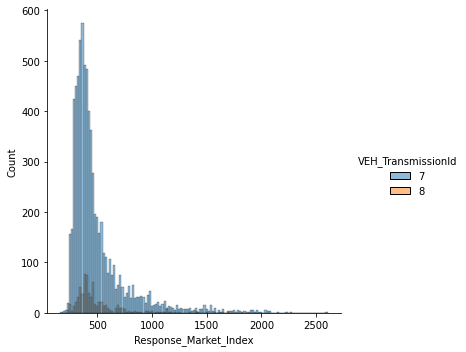

_____________Kruskal-Wallis adequacy tests_______________
Value:  16.19775373142295
p-value:  5.706173821652902e-05
#############Response vs PER_Matrimonial_Status##############
_____________Pivot_______________


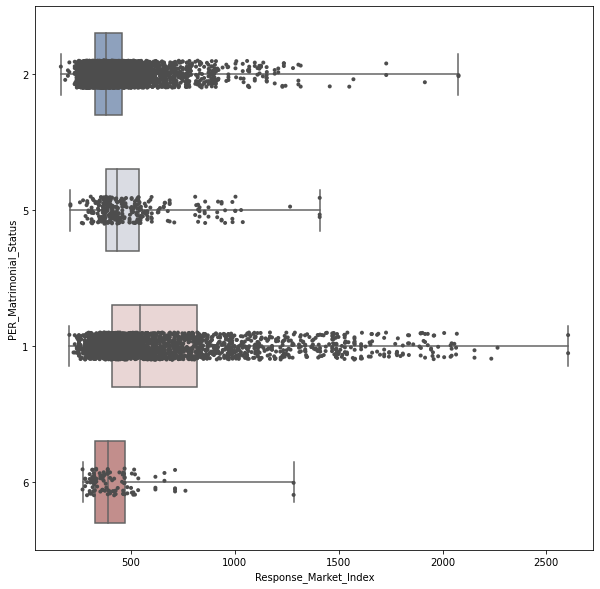

______________Conditionnal Distribution_______________


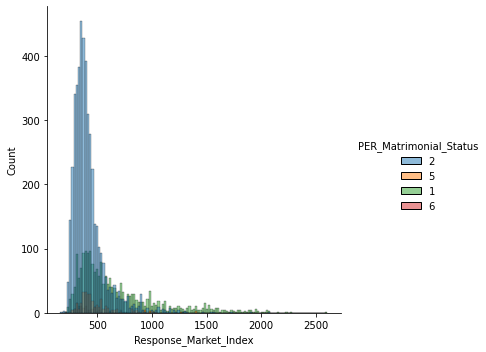

_____________Kruskal-Wallis adequacy tests_______________
Value:  1143.1576548580704
p-value:  1.577036740469146e-247
#############Response vs VEH_Injection_Mode##############
_____________Pivot_______________


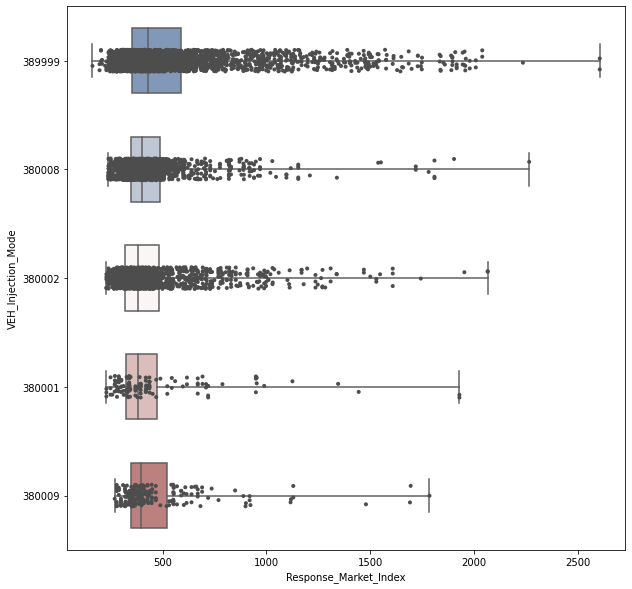

______________Conditionnal Distribution_______________


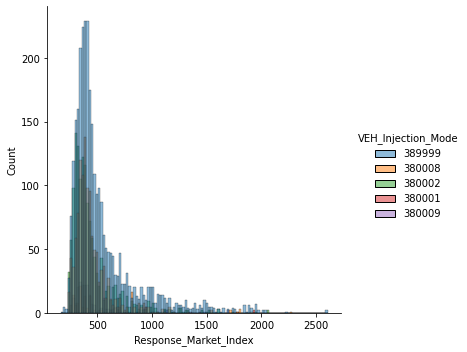

_____________Kruskal-Wallis adequacy tests_______________
Value:  151.03509931677772
p-value:  1.2215350997360436e-31
#############Response vs VEH_fuel_type##############
_____________Pivot_______________


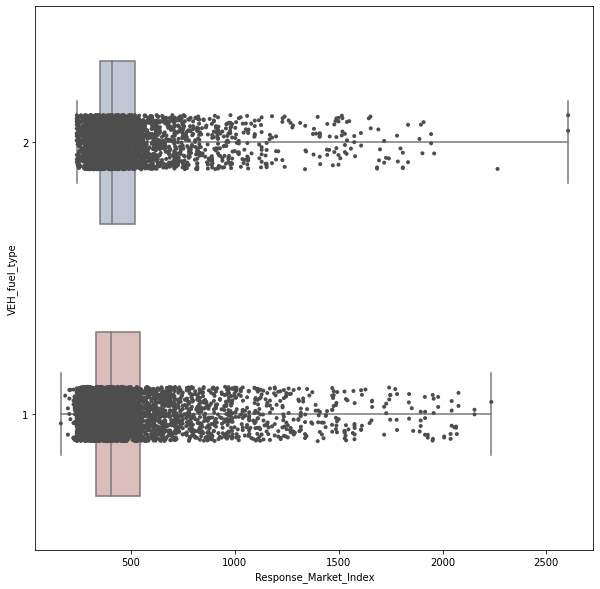

______________Conditionnal Distribution_______________


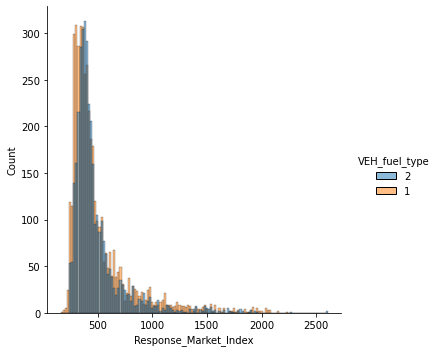

_____________Kruskal-Wallis adequacy tests_______________
Value:  9.886543718802017
p-value:  0.0016649179607661484
#############Response vs BEH_vehicule_usage##############
_____________Pivot_______________


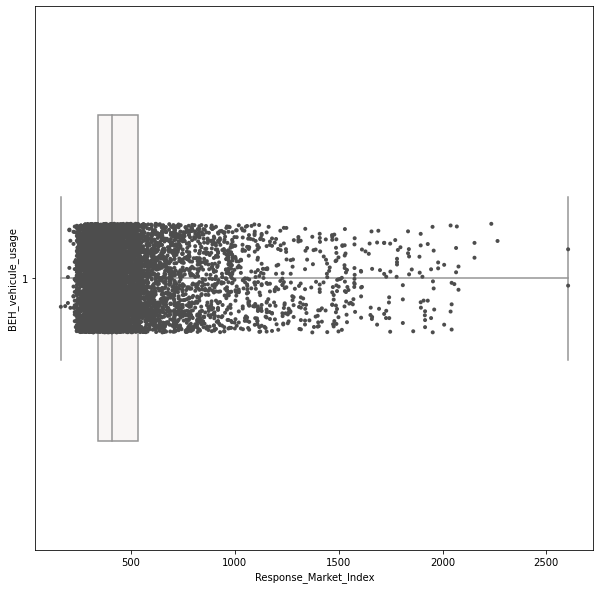

______________Conditionnal Distribution_______________


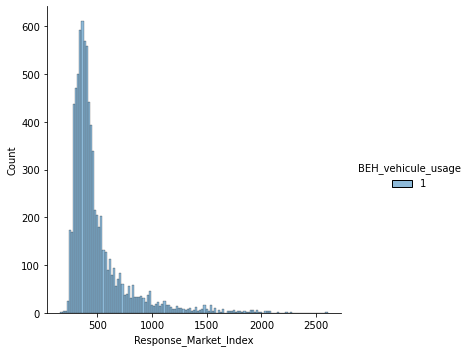

_____________Kruskal-Wallis adequacy tests_______________
No possible test for  BEH_vehicule_usage
Value:  9.886543718802017
p-value:  0.0016649179607661484
#############Response vs VEH_Drive_type##############
_____________Pivot_______________


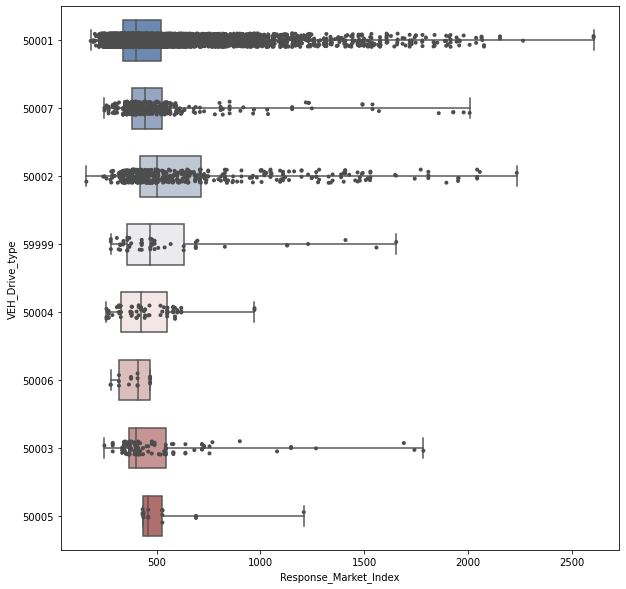

______________Conditionnal Distribution_______________


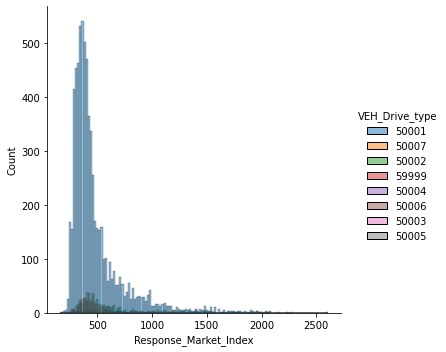

_____________Kruskal-Wallis adequacy tests_______________
Value:  238.39549357548822
p-value:  8.152624456766401e-48
#############Response vs VEH_Body##############
_____________Pivot_______________


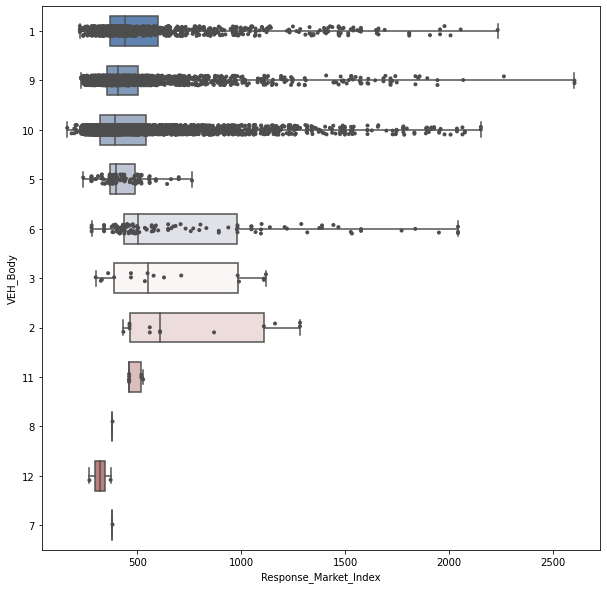

______________Conditionnal Distribution_______________


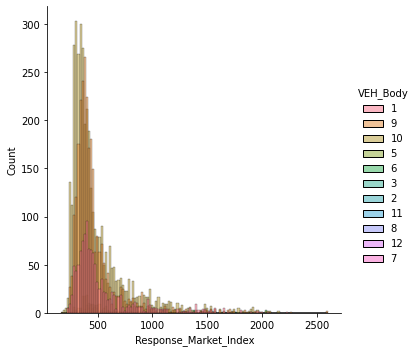

_____________Kruskal-Wallis adequacy tests_______________
Value:  197.54211978402236
p-value:  5.252257979942806e-37
#############Response vs VEH_Segment##############
_____________Pivot_______________


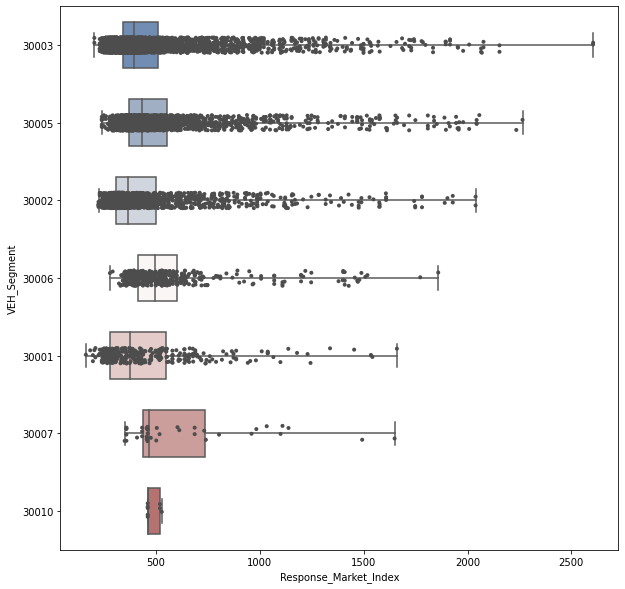

______________Conditionnal Distribution_______________


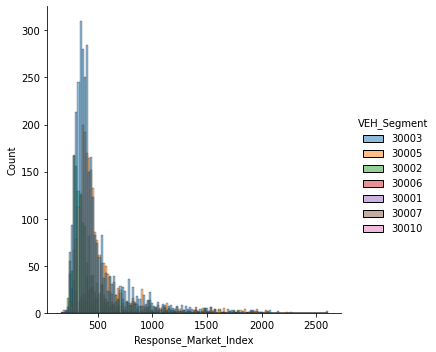

_____________Kruskal-Wallis adequacy tests_______________
Value:  429.1148777375801
p-value:  1.5310650002760376e-89
#############Response vs PER_Parking_Type##############
_____________Pivot_______________


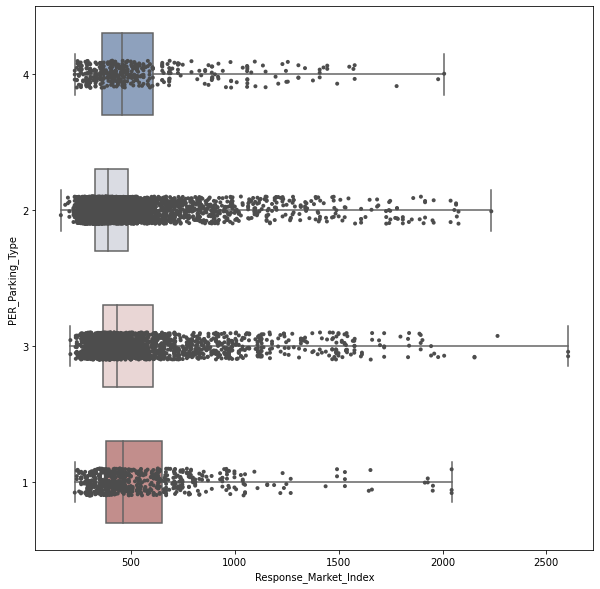

______________Conditionnal Distribution_______________


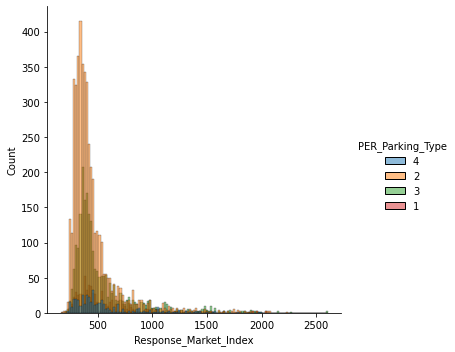

_____________Kruskal-Wallis adequacy tests_______________
Value:  348.82182224287556
p-value:  2.6840173774465933e-75
#############Response vs VEH_High_Risk_Vehicle##############
_____________Pivot_______________


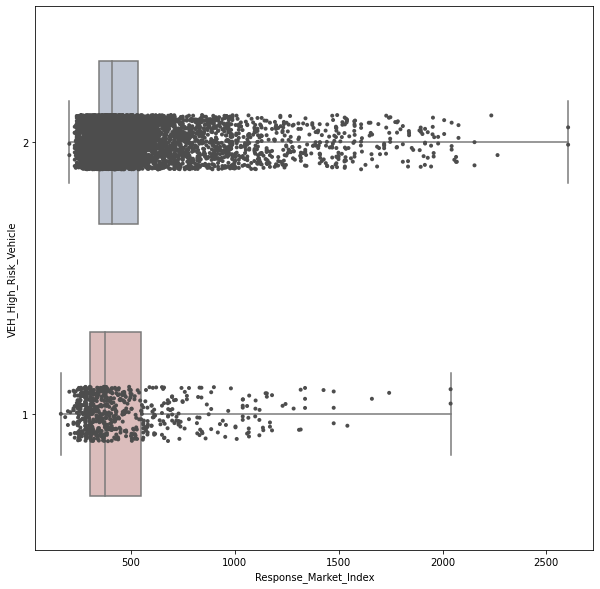

______________Conditionnal Distribution_______________


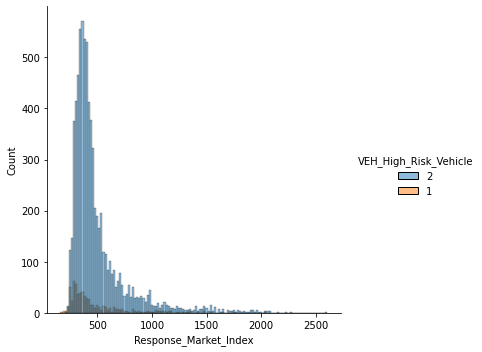

_____________Kruskal-Wallis adequacy tests_______________
Value:  42.0530053359282
p-value:  8.883256138346815e-11
#############Response vs PER_previous_insurer##############
_____________Pivot_______________


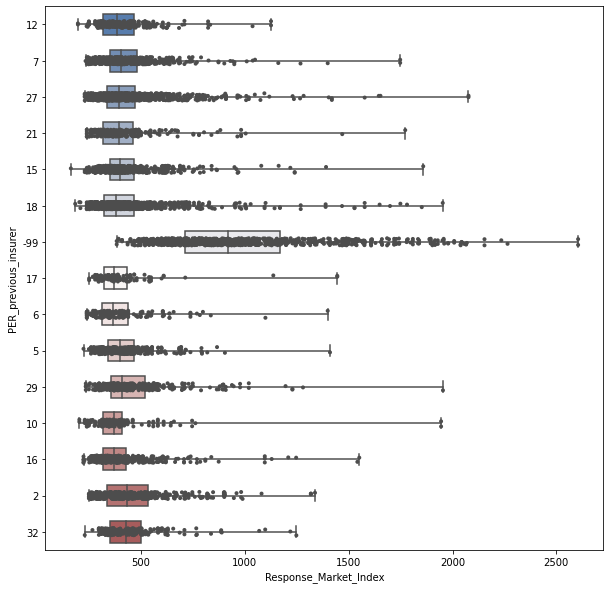

______________Conditionnal Distribution_______________


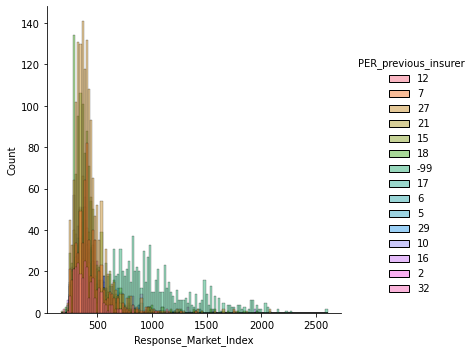

_____________Kruskal-Wallis adequacy tests_______________
Value:  2141.4311509419435
p-value:  0.0
#############Response vs PER_Is_second_driver##############
_____________Pivot_______________


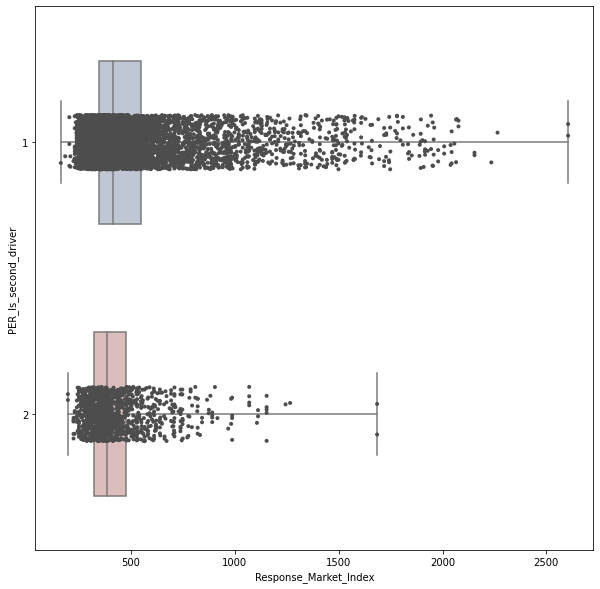

______________Conditionnal Distribution_______________


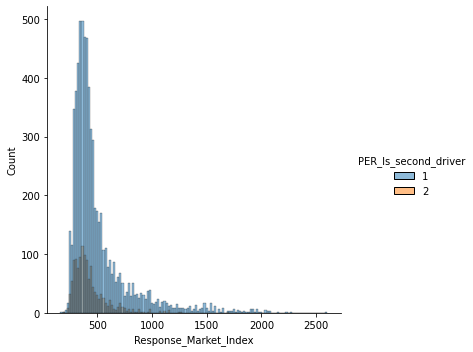

_____________Kruskal-Wallis adequacy tests_______________
Value:  74.24229593436914
p-value:  6.909394100795872e-18
#############Response vs PER_Insured_Before##############
_____________Pivot_______________


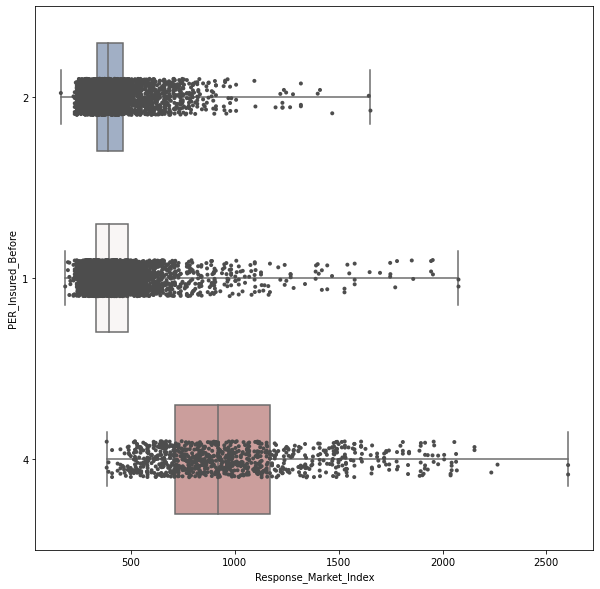

______________Conditionnal Distribution_______________


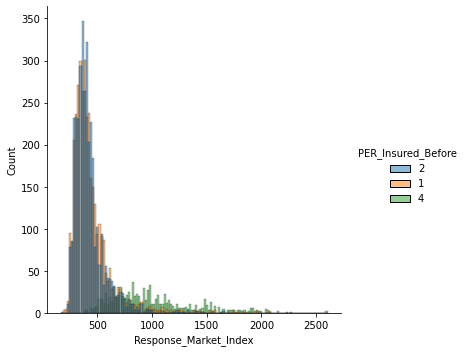

_____________Kruskal-Wallis adequacy tests_______________
Value:  2024.7803732246655
p-value:  0.0


In [ ]:
analyzer = Custom_multivariate_analysis()
analyzer.get_multivariate_analysis(X_train, y_train)

## 3. Missing values

### The 50 missing values

In [ ]:
X_train_50mv = X_train.loc[X_train['CLA_HISTORY'].isnull()]
X_train_50mv.describe()

VEH_Actual_Value  CLA_HISTORY  ...    GEO_Lat   GEO_Long
count         40.000000          0.0  ...  40.000000  40.000000
mean       19008.625000          NaN  ...   2.366814   0.659483
std        13150.317381          NaN  ...   0.045431   2.505243
min         1800.000000          NaN  ...   2.301624  -4.097747
25%         7948.750000          NaN  ...   2.326624  -0.618622
50%        14340.000000          NaN  ...   2.358524   0.368853
75%        35890.000000          NaN  ...   2.425824   3.045878
max        39603.000000          NaN  ...   2.425824   3.918653

[8 rows x 21 columns]

As expected the 50 missing values found for 'CLA_HISTORY' are at least missing everywhere. Inputation for these is not efficient, we will split the data into 2 samples, such that we will build 2 models (1 for the 50 missing values and 1 for the rest).

In [ ]:
X_train_wo50mv = X_train.loc[X_train['CLA_HISTORY'].notnull()]

### Correlation between missing values

**For the full dataset**

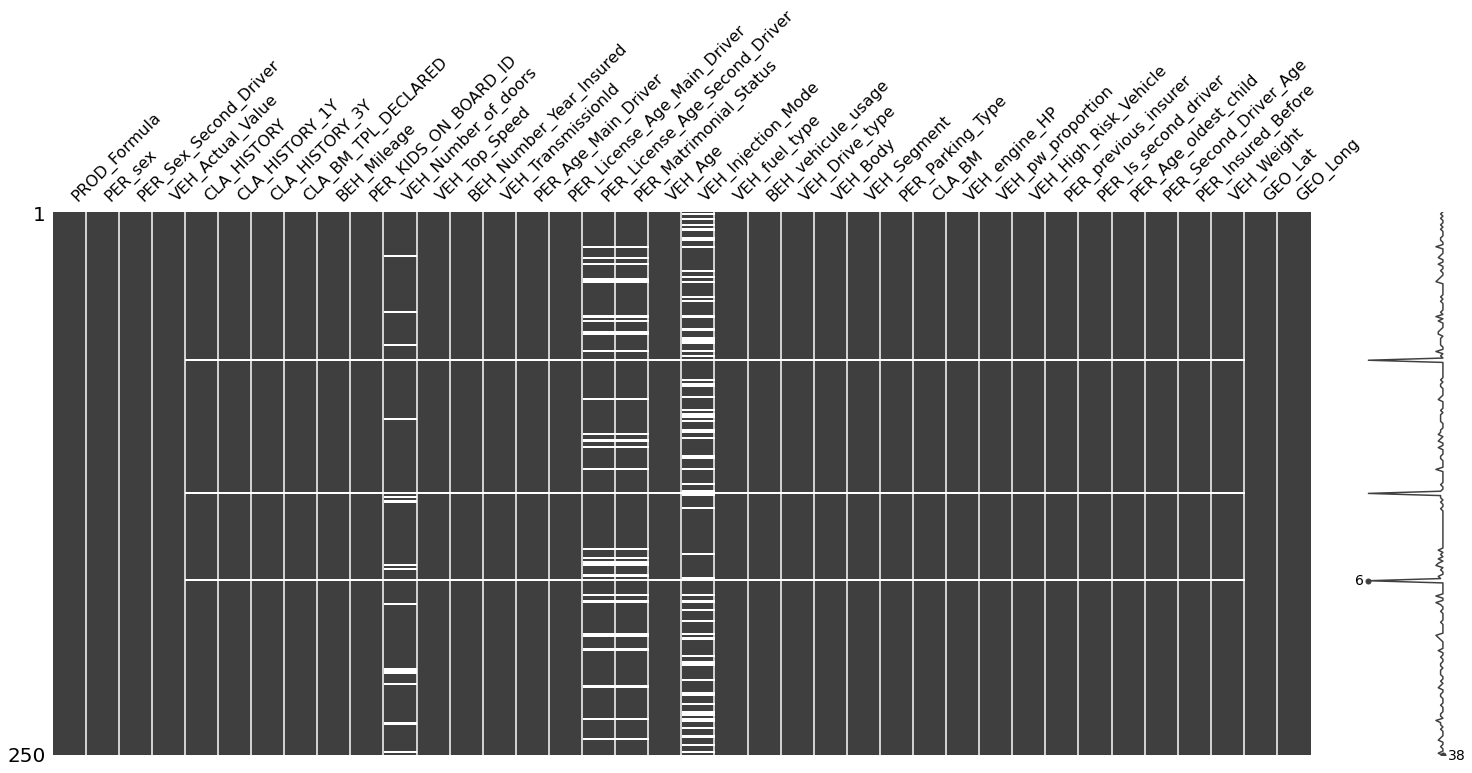

In [ ]:
missingno.matrix(X_train.sample(250))

**For the data set wo 50 missing values**

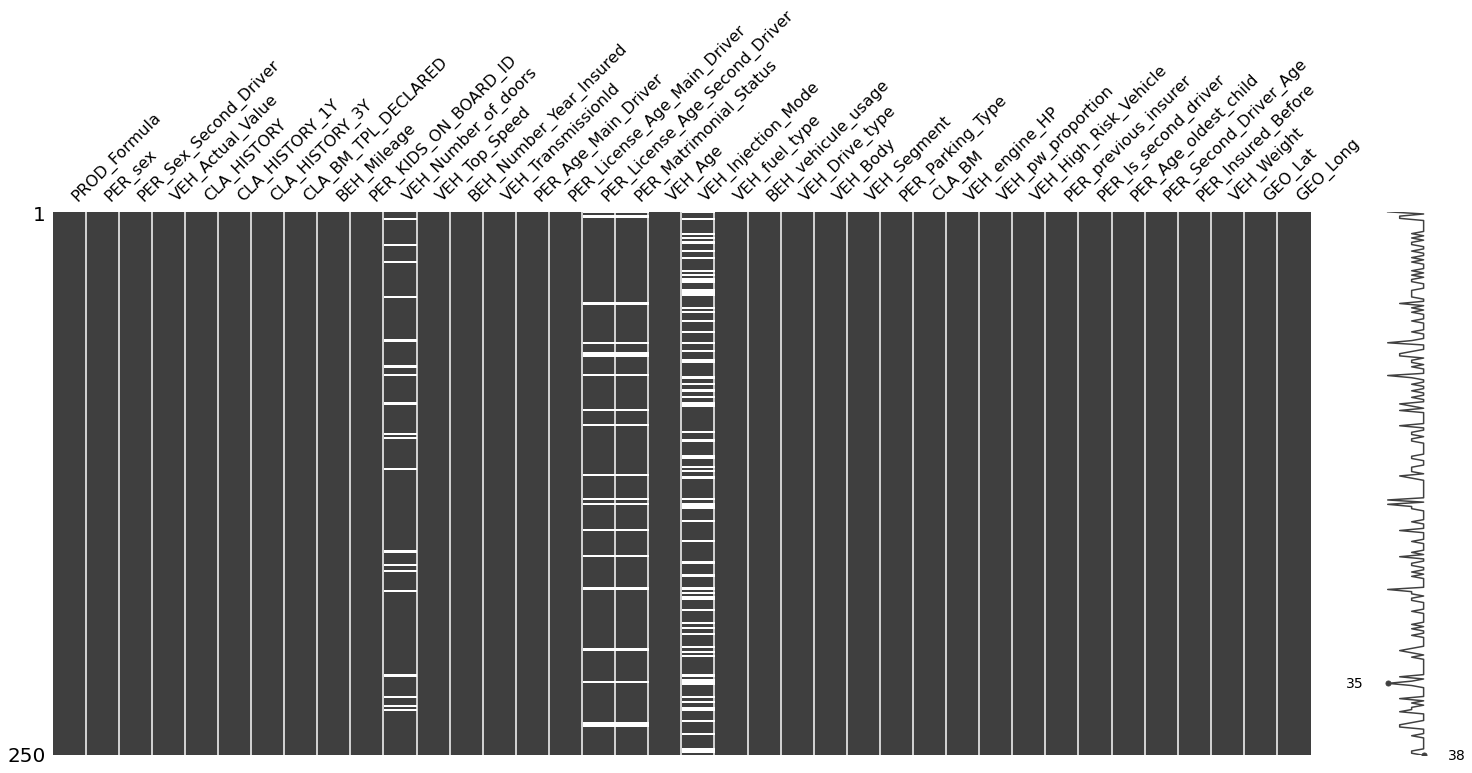

In [ ]:
missingno.matrix(X_train_wo50mv.sample(250))

PER_Licence_Age_Second_Driver & Per_Licence_Age_Main_Driver have correlated missing values (case no 2nd driver I guess).

In [ ]:
del X_train_50mv, X_train_wo50mv

## 4. Preprocessing 

Now geographical data will be treated as quantitative variables.

In [21]:
quantitative = quantitative + geographical

We will spilt the data into 2 datasets for 2 models : the  main and the one with the "50 missing values".

- For quantitative and geographical data : we will center/reduce and imput missing values (with initial strategy = mean).

- For qualitative data : we will get dummies, and imput missing values (with initial_strategy = median).

- For as_quantitative data : we will center/ reduce and imput missing values (with initial strategy = median).

In [22]:
class Custom_data_cleaner():

  def __init__(self, quantitative, as_quantitative, qualitative):

    self.quantitative = quantitative
    self.qualitative = qualitative
    self.as_quantitative = as_quantitative


  def split_50(self, XX):

    X = XX.copy()
    where_50_values = X['CLA_HISTORY'].isnull()
    where_50_values = where_50_values

    X_50 = X.loc[where_50_values]
    assert len(X_50[['VEH_Actual_Value', 'GEO_Lat', 'GEO_Long']].dropna()) == len(X_50), 'Key for suspect 50 values is wrong'
    X_wo50 = X.loc[X['CLA_HISTORY'].notnull()]

    self.where_50_values = where_50_values

    return X_50, X_wo50



  def preprocessing(self, XX, dummies = True, check = True):

    quantitative = self.quantitative
    qualitative = self.qualitative
    as_quantitative = self.as_quantitative
    X = XX.copy()

    scaler = preprocessing.StandardScaler().fit(X[quantitative + as_quantitative])
    X[quantitative + as_quantitative] = scaler.transform(X[quantitative + as_quantitative])

    if dummies : 
      X = pd.get_dummies(X, columns = qualitative, drop_first  = True)
      if check :
        for key in self.KEYS :
          if not(key in X.columns) : X[key] = zeros(X.shape[0])
        for key in X.columns :
          if not(key in self.KEYS) : del X[key]
      

    return X

  
  
  def fit(self, XX, y = None):

    quantitative = self.quantitative
    qualitative = self.qualitative
    as_quantitative = self.as_quantitative
    X = XX.copy()
    
    X_50, X_wo50 = self.split_50(X)

    X_wo50 = self.preprocessing(X_wo50, check = False)
    self.KEYS = X_wo50.columns

    imputer_quantitative = IterativeImputer()
    X_wo50_quantitative = X_wo50[quantitative]
    #print(X_wo50_quantitative)
    imputer_quantitative.fit(X_wo50_quantitative)
    self.imputer_quantitative = imputer_quantitative

    new_qualitative = list(X_wo50.keys())
    for element in quantitative : new_qualitative.remove(element)
    self.new_qualitative = new_qualitative

    imputer_qualitative = IterativeImputer(initial_strategy = "median")
    X_wo50_qualitative = X_wo50[new_qualitative]
    imputer_qualitative.fit(X_wo50_qualitative)
    self.imputer_qualitative = imputer_qualitative

   
  def imput_missing_values(self, XX_wo50):
    quantitative = self.quantitative
    qualitative = self.new_qualitative
    qualitative_imputer = self.imputer_qualitative
    quantitative_imputer = self.imputer_quantitative
    X_wo50 = XX_wo50.copy()
    X_wo50 = self.preprocessing(X_wo50)
    X_wo50_quantitative = X_wo50[quantitative]
    X_wo50_qualitative = X_wo50[qualitative]
    X_wo50[quantitative] = quantitative_imputer.transform(X_wo50_quantitative)
    X_wo50[qualitative] = qualitative_imputer.transform(X_wo50_qualitative)
    return X_wo50


  def transform(self, XX, y = None):

    quantitative = self.quantitative
    new_qualitative = self.new_qualitative
    qualitative = self.qualitative

    X = XX.copy()
    X_50, X_wo50 = self.split_50(X)
    X_wo50 = self.imput_missing_values(X_wo50)
    X_50 = self.preprocessing(X_50, dummies = False, check = False)
    X_50 = X_50[['VEH_Actual_Value', 'GEO_Lat', 'GEO_Long']]
    return X_50, X_wo50


  def fit_transform(self, X, y = None):

    self.fit(X)
    return self.transform(X)


**TESTS**

In [23]:
processor = Custom_data_cleaner(quantitative, as_quantitative, qualitative)
X_50_test, X_wo50_test = processor.fit_transform(X_train)

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


In [24]:
X_50_test.describe()

VEH_Actual_Value       GEO_Lat      GEO_Long
count      3.600000e+01  3.600000e+01  3.600000e+01
mean      -2.312965e-18  4.650601e-15 -1.541976e-17
std        1.014185e+00  1.014185e+00  1.014185e+00
min       -1.484899e+00 -1.467820e+00 -1.842918e+00
25%       -9.785099e-01 -8.814275e-01 -4.550925e-01
50%       -3.558803e-01 -1.224278e-01 -6.118804e-02
75%        1.257406e+00  8.765671e-01  1.006679e+00
max        1.556091e+00  1.468871e+00  1.354830e+00

In [25]:
X_wo50_test.describe()

VEH_Actual_Value  ...  PER_Insured_Before_4
count      7.950000e+03  ...           7950.000000
mean       2.536057e-17  ...              0.114717
std        1.000063e+00  ...              0.318700
min       -8.733069e-01  ...              0.000000
25%       -5.060925e-01  ...              0.000000
50%       -2.290097e-01  ...              0.000000
75%        2.381374e-01  ...              0.000000
max        4.271101e+01  ...              1.000000

[8 rows x 81 columns]

In [26]:
X_test.shape

(1997, 38)

## Pipeline

**I strongly recomment to do NOT run this part**

Because the purpose of this exercise is not to chose a model or to tune hyperparameters, and also because we must not over-feature engineer, we will build a pipeline (using the tpot - package). We will then check the auto-generated code.

#### Preparation

In [93]:
class Custom_pipeline() :

  def __init__(self, quantitative, as_quantitative, qualitative, random_state = 2021):

    self.data_cleaner = Custom_data_cleaner(quantitative, as_quantitative, qualitative)
    self.random_state = random_state


  def fit(self, 
          X, 
          yy,
          path_model50 = 'TPOTmodel_50.py', 
          path_modelwo50 = 'TPOTmodel_wo50.py',
          fit_50 = True,
          fit_wo50 = False):

      random_state = self.random_state
      X_50, X_wo50 = self.data_cleaner.fit_transform(X)
      where_50_values = self.data_cleaner.where_50_values
      y = yy.values
      y_50 = y[where_50_values]
      y_wo50 = y[where_50_values == False]
     
      if(fit_50):
        print('################# 50 missing values ###############')
        self.model_50 = tpot.TPOTRegressor(generations = 5, 
                                      population_size = 100, 
                                      cv = 10, 
                                      scoring = 'neg_mean_absolute_error', 
                                      verbosity = 2, 
                                      random_state = random_state, 
                                      n_jobs = 10,
                                      periodic_checkpoint_folder = 'model_50.py',
                                      early_stop = 5)
        
        self.model_50.fit(X_50, y_50)
        self.model_50.export(path_model50)

      if(fit_wo50):
        print('###############Other data####################')
        self.model_wo50 = tpot.TPOTRegressor(generations = 5, 
                                            population_size = 50, 
                                            cv = 10, 
                                            scoring = 'neg_mean_absolute_error', 
                                            verbosity = 2 , 
                                            random_state = random_state, 
                                            n_jobs = 10,
                                            periodic_checkpoint_folder = 'model_wo50.py',
                                            early_stop = 5)
        self.model_wo50.fit(X_wo50, y_wo50)
        self.model_wo50.export(path_modelwo50)


  def export_model(self, 
                   path_model50 = 'TPOTmodel_50.py', 
                   path_modelwo50 = 'TPOTmodel_wo50.py'):
    self.model_wo50.export('tpot_insurance_best_model.py')
    self.model_50.export('tpot_insurance_best_model.py')
  



#### Model for 50 missing values

In [91]:
pipeline = Custom_pipeline(quantitative, as_quantitative, qualitative)
pipeline.fit(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning:

Degrees of freedom <= 0 for slice.



################# 50 missing values ###############



Generation 1 - Current best internal CV score: -30.91301417208289

Generation 2 - Current best internal CV score: -30.91301417208289

Generation 3 - Current best internal CV score: -30.75122133837649

Generation 4 - Current best internal CV score: -28.586861754523795

Generation 5 - Current best internal CV score: -28.586861754523795

Best pipeline: KNeighborsRegressor(SGDRegressor(input_matrix, alpha=0.0, eta0=1.0, fit_intercept=True, l1_ratio=0.25, learning_rate=constant, loss=squared_loss, penalty=elasticnet, power_t=50.0), n_neighbors=28, p=1, weights=distance)


#### Model for the clean database

In [94]:
pipeline = Custom_pipeline(quantitative, as_quantitative, qualitative)
pipeline.fit(X_train, y_train, fit_50 = False, fit_wo50 = True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning:

Degrees of freedom <= 0 for slice.



###############Other data####################



Generation 1 - Current best internal CV score: -46.80739503536537

Generation 2 - Current best internal CV score: -40.881336832707504

Generation 3 - Current best internal CV score: -40.8540243843035

Generation 4 - Current best internal CV score: -32.41283003516151

Generation 5 - Current best internal CV score: -32.41283003516151

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)


## 5. Model

In [97]:
class Full_model():

  def __init__(self, X, quantitative = quantitative, as_quantitative = as_quantitative, qualitative = qualitative, y = None):
    self.preprocessor = Custom_data_cleaner(quantitative, as_quantitative, qualitative)
    self.preprocessor.fit(X)

  
  def fit(self, X, y):
    X_50, X_wo50 = self.preprocessor.transform(X)
    where_50 = self.preprocessor.where_50_values
    y_50 = y[where_50]
    y_wo50 = y[where_50 == False]
    self.feature_names_wo50 = X_wo50.columns
    self.feature_names_50 = X_50.columns

    self.model_50 = KNeighborsRegressor(n_neighbors=28, p=1, weights="distance")
    
    self.model_50.fit(X_50, y_50)

    self.model_wo50 = RandomForestRegressor(bootstrap=False, max_features=0.65, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
         
    self.model_wo50.fit(X_wo50, y_wo50)

  def predict(self, X):
    X_50, X_wo50 = self.preprocessor.transform(X)
    where_50 = self.preprocessor.where_50_values
    predictions_50 = self.model_50.predict(X_50)
    predictions_wo50 = self.model_wo50.predict(X_wo50)
    output = zeros(X.shape[0])
    output[where_50] = predictions_50
    output[where_50 == False] = predictions_wo50
    return output

  def eval_score(self, X, y):
    y_pred = self.predict(X)
    return mean(abs((y - y_pred) / y)) * 100

  

In [98]:
model = Full_model(X_train)
model.fit(X_train, y_train)

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


In [99]:
print('###########Calibration Score############')
print(model.eval_score(X_train, y_train))
print('############Prediction Score############')
print(model.eval_score(X_test, y_test) )

###########Calibration Score############


invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


0.9477022511535365
############Prediction Score############
13.59844560039819


invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


## 6. Model assessment & feature selection

#### Residual plot

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


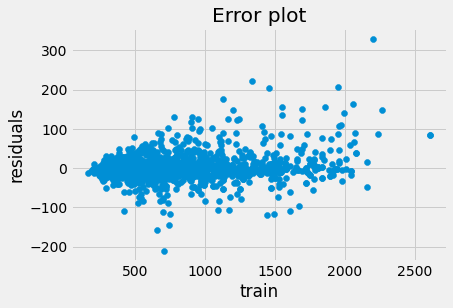

In [100]:
figure()
scatter(y_train, y_train - model.predict(X_train))
title('Error plot')
grid(True)
xlabel('train')
ylabel('residuals')
show()

Errors on calibration set seem to be centered, Even if for large values the standard deviations are more important (2nd model?)

Let's visualize the main model's variable importances through regular random forests feature importances & shape ratios

#### RF feature importances

Text(0.5, 1.0, 'Variable Importances')

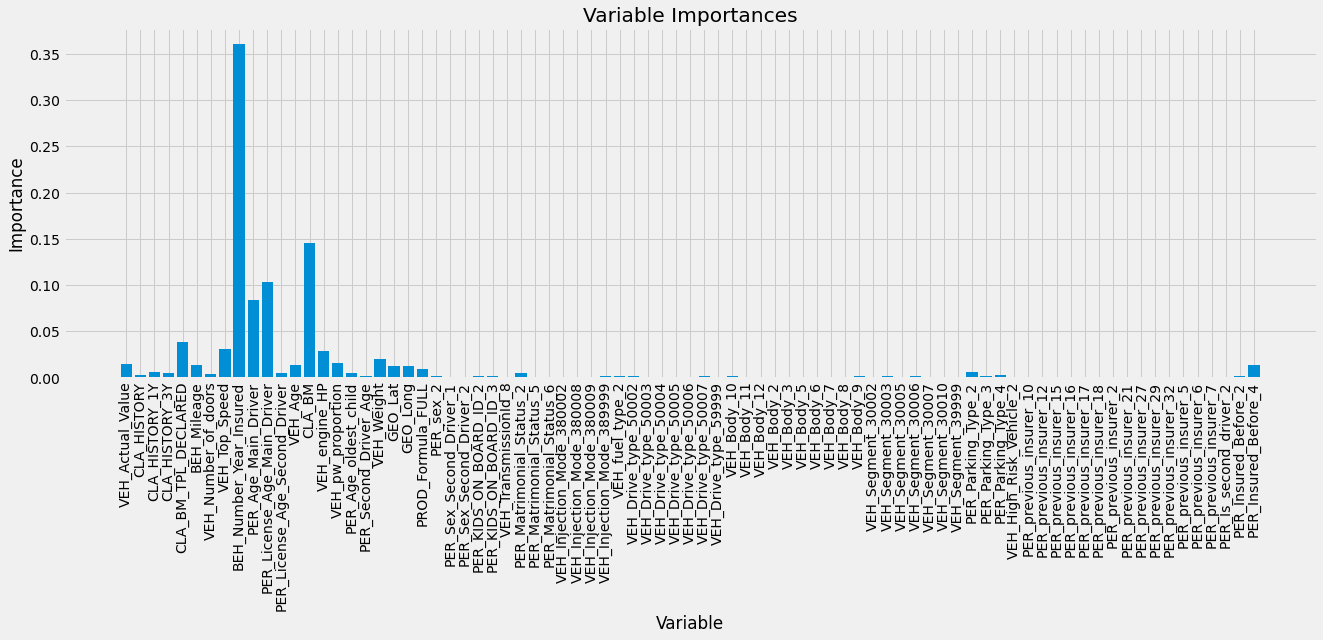

In [101]:
importances = list(model.model_wo50.feature_importances_)

# Set the style
style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

figure(figsize=(20,6))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, model.feature_names_wo50, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

#### Calibration shape ratios

In [102]:
X_50, X_wo50 = Custom_data_cleaner(quantitative, as_quantitative, qualitative).fit_transform(X_train)

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


In [103]:
explainer = shap.TreeExplainer(model.model_wo50)

In [104]:
shap_values = explainer.shap_values(X_wo50, approximate = True, tree_limit = 100)

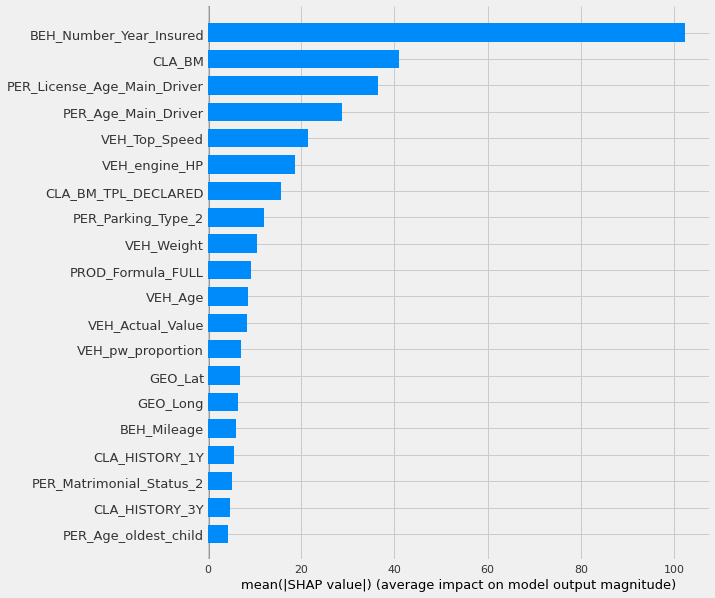

In [105]:
shap.summary_plot(shap_values, X_wo50, plot_type="bar")

We have close feature importances for the default RF method and the approximated shape ratios.

## 2nd Model

We'll keep variables with a posterior importance greater than 0.1% (to decrease noise in data).

In [106]:
selected_features = array( model.feature_names_wo50[array(importances) > 0.001] )
selected_features

array(['VEH_Actual_Value', 'CLA_HISTORY', 'CLA_HISTORY_1Y',
       'CLA_HISTORY_3Y', 'CLA_BM_TPL_DECLARED', 'BEH_Mileage',
       'VEH_Number_of_doors', 'VEH_Top_Speed', 'BEH_Number_Year_Insured',
       'PER_Age_Main_Driver', 'PER_License_Age_Main_Driver',
       'PER_License_Age_Second_Driver', 'VEH_Age', 'CLA_BM',
       'VEH_engine_HP', 'VEH_pw_proportion', 'PER_Age_oldest_child',
       'PER_Second_Driver_Age', 'VEH_Weight', 'GEO_Lat', 'GEO_Long',
       'PROD_Formula_FULL', 'PER_sex_2', 'PER_KIDS_ON_BOARD_ID_2',
       'PER_KIDS_ON_BOARD_ID_3', 'PER_Matrimonial_Status_2',
       'VEH_Injection_Mode_389999', 'VEH_fuel_type_2',
       'VEH_Drive_type_50002', 'VEH_Drive_type_50007', 'VEH_Body_10',
       'VEH_Body_9', 'VEH_Segment_30002', 'VEH_Segment_30003',
       'VEH_Segment_30005', 'VEH_Segment_30006', 'PER_Parking_Type_2',
       'PER_Parking_Type_3', 'PER_Parking_Type_4',
       'PER_previous_insurer_27', 'PER_previous_insurer_7',
       'PER_Insured_Before_2', 'PER_Insured_B

In [131]:
class Second_processor():

  def __init__(self, 
               quantitative = quantitative, 
               as_quantitative = as_quantitative,
               qualitative = qualitative, 
               selected_features = selected_features):

    self.quantitative = quantitative
    self.qualitative = qualitative
    self.selected_features = selected_features
    self.first_processor = Custom_data_cleaner(quantitative, as_quantitative, qualitative)

  def fit(self, X, y = None):
    self.first_processor.fit(X)
    self.where_50_values = self.first_processor.where_50_values

  def transform(self, X, y = None):
    X_50, X_wo50 = self.first_processor.transform(X)
    self.where_50_values = self.first_processor.where_50_values
    XX_wo50 = X_wo50[selected_features]
    return X_50, XX_wo50

  def fit_transform(self, X, y = None):
    self.fit(X)
    return self.transform(X)

In [109]:
XX_50, XX_wo50 = Second_processor().fit_transform(X_train)

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


In [110]:
XX_50.head()

VEH_Actual_Value   GEO_Lat  GEO_Long
9505          1.488117 -0.122428  1.354830
6820          1.257406 -0.122428  1.354830
8363         -1.484899  1.468871 -0.061188
2766          0.210520 -0.503110 -0.519924
2686         -0.355880 -0.122428  1.354830

In [111]:
XX_wo50.head()

VEH_Actual_Value  CLA_HISTORY  ...  PER_Insured_Before_2  PER_Insured_Before_4
5360         -0.363573    -0.260594  ...                   0.0                   1.0
8657         -0.269675     0.252082  ...                   0.0                   0.0
2690          0.045882    -0.260594  ...                   1.0                   0.0
8868         -0.097598     0.252082  ...                   1.0                   0.0
9579          0.106226    -0.260594  ...                   1.0                   0.0

[5 rows x 43 columns]

In [112]:
class Second_model():

  def __init__(self, 
               X, 
               y = None, 
               quantitative = quantitative, 
               as_quantitative = as_quantitative, 
               qualitative = qualitative, 
               selected_features = selected_features):
    self.preprocessor = Second_processor(quantitative, as_quantitative, qualitative, selected_features)
    self.preprocessor.fit(X)

  
  def fit(self, X, y):
    X_50, X_wo50 = self.preprocessor.transform(X)
    where_50 = self.preprocessor.where_50_values
    y_50 = y[where_50]
    y_wo50 = y[where_50 == False]
    self.feature_names_wo50 = X_wo50.columns
    self.feature_names_50 = X_50.columns

    self.model_50 = KNeighborsRegressor(n_neighbors=28, p=1, weights="distance")
    
    self.model_50.fit(X_50, y_50)

    self.model_wo50 = RandomForestRegressor(bootstrap=False, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
         
    self.model_wo50.fit(X_wo50, y_wo50)

  def predict(self, X):
    X_50, X_wo50 = self.preprocessor.transform(X)
    where_50 = self.preprocessor.where_50_values
    predictions_50 = self.model_50.predict(X_50)
    predictions_wo50 = self.model_wo50.predict(X_wo50)
    output = zeros(X.shape[0])
    output[where_50] = predictions_50
    output[where_50 == False] = predictions_wo50
    return output

  def eval_score(self, X, y):
    y_pred = self.predict(X)
    return mean(abs((y - y_pred) / y)) * 100

In [113]:
model = Second_model(X_train)
model.fit(X_train, y_train)

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


In [114]:
print('###########Calibration Score############')
print(model.eval_score(X_train, y_train))
print('############Prediction Score############')
print(model.eval_score(X_test, y_test) )

###########Calibration Score############


invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


1.399521051914927
############Prediction Score############
9.50825403893927


invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


## Predictions diagnostic

### Residual plot

invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


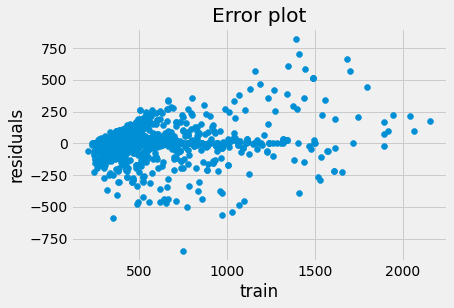

In [115]:
figure()
scatter(y_test, y_test - model.predict(X_test))
title('Error plot')
grid(True)
xlabel('train')
ylabel('residuals')
show()

### Shape : Variable importance ~ Local predictions

In [ ]:
explainer = shap.TreeExplainer(model.model_wo50)
processor = Second_processor(quantitative, as_quantitative, qualitative, selected_features)
processor.fit(X_train)
XX_test_50, XX_test_wo50 = processor.transform(X_test)
shap_values = explainer.shap_values(XX_test_wo50, tree_limit = 100, approximate = True)

In [138]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], XX_test_wo50.iloc[0,:])

### Shape Variable importance ~ All predictions

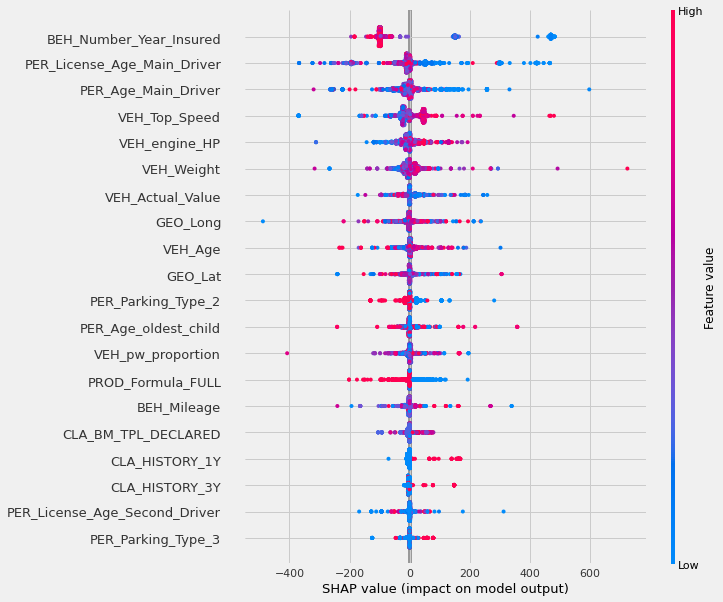

In [140]:
shap.summary_plot(shap_values, XX_test_wo50)

Most of variables are relevent.